<head><b><center>REDES NEURONALES ARTIFICIALES</center>
<center>Redes Convolucionales (segunda parte)</center>
<center>con Autoencoders</center>
<center>Profesor: Gabriel Jara </center></b></head>

El presente Jupyter Notebook busca:
<ul>
    <li>Profundizar en las Redes Neuronales de Convolución (CNN)</li>
    <li>Utilizar librerías para mejorar el desempeño</li>
    <li>Observar como la CNN obtienen representación de características</li>
    <li>Presentar la arquitectura de <i>Autoencoders</i></li>
    <li>Observar que las ANN generan codificación compacta de la información en vectores latentes</li>
</ul>


Las imágenes han sido robadas de internet y son enlaces a su correspondiente fuente. 


<b>En el capítulo anterior </b>

Presentamos las Redes Neuronales de Convolución (CNN), una topología de red neuronal que recibe matrices bidimensionales (podemos extender a más dimensiones), y procesa la información usando filtros (<i>kernels</i>).

<br> <img src="https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif" width="300"/> </br>

La arquitectura de las CNN se diferencia del <i>Multi-Layer Perceptron</i> que ya asociamos a las ANN estándar (sabor vainilla), en que no conecta todos los perceptrones (nodos) entre capas, sino que usa los filtros que recorren la matriz de entrada.

Nuestro problema ha sido el tiempo requerido para el entrenamiento. Impacta negativamente el que no hayamos optimizado nuestra implementación, por ejemplo, usando <i>Mini Batch</i> para resumir los ajustes que se ejecutan sobre los pesos en cada epoch, o aplicando <i>Pooling</i> entre las capas de convolución para controlar mejor el tamaño del modelo. Esto último, además de reducir el tiempo de entrenamiento, tiene el potencial de mejorar la capacidad de generalización de nuestros modelos CNN.

<b>Relajaremos nuestro voto de no librerías</b>

Podemos y vamos a mejorar nuestra implementación en Python sin librerías. Sin embargo, el uso de librerías optimizadas todavía dará resultados más rápidos que nuestra propia implementación. Entre otros factores, destaca el que, por lo general, las librerías para Machine Learning se ejecutan sobre implementaciones en lenguajes de más bajo nivel (con mayor desempeño). Por ejemplo, <i>keras</i>, que ya hemos usado para crear modelos basados en redes neuronales, se ejecuta sobre <i>TensorFlow</i>, que está implementado mayoritariamente en <i>C++</i>. Python juega el rol de lenguaje interfaz, nos permite organizar nuestros experimentos, manipular datos y resultados, pero a la vez descansar en implementaciones en otros lenguajes y así obtener más potencia de cómputo. Esto es muy significativo, sobre todo cuando se quiere aprovechar el uso de GPU.

Dado que el tiempo de ejecución será un tema en este Jupyter, vamos a tomar el tiempo que tarde de principio a fin.

In [1]:
import time

#Esto se va a demorar, registremos cuanto. 
inicio = time.time()

<b>Clasificación de MNIST</b>

Comencemos por reproducir cosas que ya hacíamos con nuestra Red Neuronal sin librerías, pero esta vez usando implementaciones <i>profesionales</i>. Empecemos por clasificar los dígitos de MNIST.

In [2]:
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
import random
import matplotlib.pyplot as plt

# No necesitamos tantos datos.
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#random.seed(123) # Vamos a controlar la aleatoriedad en adelante. 
X, y = zip(*random.sample(list(zip(X_train, y_train)), 2000))

# Reshape
X, y = np.array(X, dtype='float64'), np.array(y, dtype='float64')
X = X.reshape(X.shape[0], 28, 28, 1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)
y_train_value = y_train # Guardaremos y_train con su valor original. 

# Representación categórica
y_train_value = y_train
y_train = to_categorical(y_train)
y_test = to_categorical(y_test) 

# Estandarización, se calcula con X_train y aplica a X_train y X_test
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

A continuación, vamos a usar la implementación de Keras - TensorFlow para crear nuestro modelo convolucional, como ya habíamos anunciado.

Note que la mecánica para definir la topología del modelo es similar a la que usábamos en nuestra implementación propia: creamos el modelo (vacío) y luego agregamos capas una a una. Podemos usar capas densas y de convolución.

Observe que en cada capa encontramos hiperparámetros similares a los que habíamos incluido en nuestra propia implementación. Por ejemplo, en una capa de convolución identificamos cuántos filtros (<i>kernels</i>) se van a usar, de qué forma/tamaño, qué tipo de <i>padding</i> y qué función de activación. Si es la primera capa del modelo, necesita que se le informe el tamaño de la entrada, mientras que las capas posteriores lo infieren automáticamente a partir del tamaño de la salida (algo que nuestra implementación básica NO hace).

Una vez agregadas las capas, es necesario <b>compilar</b>. La compilación de un modelo en Keras está estrechamente relacionada con la implementación subyacente de TensorFlow en C++. Cuando creamos un modelo secuencial en Keras y lo compilamos, lo que realmente estamos haciendo es traducirlo a una estructura de tipo grafo, diseñada para un entrenamiento eficiente. Durante este proceso, Keras traduce las capas y operaciones definidas en código Python a operaciones que pueden ser ejecutadas de manera eficiente por TensorFlow, sobre todo debido a su capacidad de paralelización.

Finalmente, el modelo se entrena, que es cuando necesita acceder a los datos de entrenamiento ($X$ e $y$), y se definen el número de epochs y el tamaño del <i>mini-batch</i>.

In [3]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers

X_shape = X_train[0].shape

# Creamos la CNN con una capa de convolución 
model = Sequential()
model.add(layers.Conv2D(filters=16, 
                        kernel_size=(3, 3), 
                        padding='same', 
                        activation='relu', 
                        input_shape=X_shape))
model.add(layers.Flatten())

# Dese acá es una red neuronal fully connected, como ya conocíamos.
# Agregamos una capa oculta.
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(10, activation='sigmoid'))


# Compilamos el modelo indicando la función de perdida, optimizador y métricas.
# vamos a usar Entropía Categórica, ADAM y Exactitud de clasificación, respectivamente. 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamos el modelo con los datos de entrenamiento
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluamos el modelo con datos de testeo
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy:', accuracy)

Epoch 1/10
32/32 [==============================] - 1s 9ms/step - loss: 0.8903 - accuracy: 0.7140
Epoch 2/10
32/32 [==============================] - 0s 9ms/step - loss: 0.2298 - accuracy: 0.9290
Epoch 3/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1066 - accuracy: 0.9730
Epoch 4/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0508 - accuracy: 0.9910
Epoch 5/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0279 - accuracy: 0.9950
Epoch 6/10
32/32 [==============================] - 0s 8ms/step - loss: 0.0127 - accuracy: 1.0000
Epoch 7/10
32/32 [==============================] - 0s 9ms/step - loss: 0.0081 - accuracy: 1.0000
Epoch 8/10
32/32 [==============================] - 0s 9ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 9/10
32/32 [==============================] - 0s 9ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 10/10
32/32 [==============================] - 0s 3ms/step - loss: 0.3693 - accuracy: 0.9090
Accuracy: 0.9089999

La exactitud reportada sobre la muestra de validación no deja duda de que esta red neuronal ha <i>aprendido</i> a reconocer los dígitos manuscritos, que clasifica con alto éxito. Un modelo <i>tonto</i> difícilmente lograría mucho más que un 10% de exactitud en este problema. Podemos afirmar que la red aprendió gracias a nuestro método de validación, que se basa en entrenar con un conjunto de datos y evaluar con otro, donde el modelo clasifica correctamente observaciones que nunca había visto, lo que demuestra que aprendió.

<b>¿En qué consiste el aprendizaje que demuestra la red?</b>

Ya hemos discutido que, en general, el <i>conocimiento</i> adquirido por la ANN queda registrado en el valor numérico de los pesos $W$ que conectan densamente las capas de neuronas. En el caso de una red convolucional es similar, pero ya no tenemos solo la red densamente conectada, también tenemos los <i>kernels</i> o filtros que recorren cada observación desde que ingresa al modelo.

Cada uno de estos kernels recorre la imagen original, actuando como filtros que sirven para construir una nueva versión de la imagen, píxel por píxel. Los kernels en sí son bastante simples, típicamente son de tamaño reducido (en este ejemplo usaremos 16 kernels de 3x3), por lo que no son más que una pequeña matriz de pesos.

Cada imagen que ingrese al modelo será transformada en una nueva versión de sí misma, usando cada kernel. Esto significa que esos 9 pesos (en nuestro ejemplo con kernels 3x3) se utilizan para filtrar la imagen píxel por píxel, y será esta nueva versión de la imagen la que se transmitirá hacia adelante durante la propagación hacia adelante (<i>forward propagation</i>). Esos 9 pesos (de cada kernel) son los que se ajustan según el error de salida durante la propagación hacia atrás (<i>backward propagation</i>), y esto ocurre para cada uno de los 16 kernels. En términos de tamaño del modelo, nuestra capa de convolución con 16 kernels de 3x3 tendría 144 pesos $w$ en total, si fuera una capa densa.

<b>¿Por qué simplemente no usamos una capa densa de 144 neuronas?</b>

La razón principal es que una capa densa no tendría en cuenta la estructura espacial de la imagen. En una imagen, los píxeles cercanos suelen estar altamente correlacionados y llevan información importante en conjunto. Si usáramos una capa densa, estaríamos conectando cada píxel de la imagen a todas las neuronas de la capa, ignorando por completo estas relaciones locales. Por otro lado, las capas convolucionales, como las que emplean los kernels de 3x3, preservan esta estructura local al aplicar los filtros solo sobre pequeños grupos de píxeles vecinos. Esto permite que la red aprenda características importantes, como bordes, texturas y patrones, que son fundamentales para entender el contenido de una imagen.

<b>Podemos visualizar los kernels a los que convergió el modelo ya entrenado:</b>

Forma de los kernels: (3, 3, 1, 16)


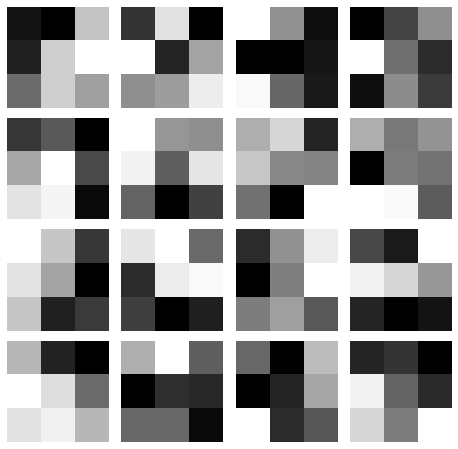

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Función para visualizar los kernels (filtros) de la primera capa de convolución
def visualize_kernels(model, layer_index=0):
    # Obtenemos los pesos de la capa de convolución
    layer = model.layers[layer_index]
    kernels, biases = layer.get_weights()
    
    # Los kernels tienen forma (alto, ancho, canales de entrada, número de filtros)
    print(f'Forma de los kernels: {kernels.shape}')
    
    # Normalizamos los valores de los kernels para visualizarlos correctamente
    min_val = np.min(kernels)
    max_val = np.max(kernels)
    kernels = (kernels - min_val) / (max_val - min_val)
    
    # Obtenemos el número de filtros y el número de canales de entrada
    num_filters = kernels.shape[-1]
    num_channels = kernels.shape[-2]
    
    # Ajustamos el número de columnas y filas para que haya 4 filtros por fila
    cols = 4
    rows = int(np.ceil(num_filters / cols))
    
    # Si solo hay un canal de entrada (como en MNIST), ajustamos el grid
    if num_channels == 1:
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))  # Ajustamos tamaño
        fig.subplots_adjust(hspace=0.1, wspace=0.1)
        
        for i in range(num_filters):
            row = i // cols  # Calculamos la fila
            col = i % cols   # Calculamos la columna
            ax = axes[row, col] if rows > 1 else axes[col]  # Si hay solo una fila, se ajusta el acceso
            ax.imshow(kernels[:, :, 0, i], cmap='gray')
            ax.axis('off')  # Ocultamos los ejes
        
        # Si sobran posiciones en la cuadrícula, ocultamos esos ejes
        for j in range(i + 1, rows * cols):
            row = j // cols
            col = j % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            ax.axis('off')
    else:
        # Si hay múltiples canales, ajustamos para visualizarlos todos
        fig, axes = plt.subplots(num_channels, num_filters, figsize=(num_filters, num_channels))
        fig.subplots_adjust(hspace=0.1, wspace=0.1)
        
        for i in range(num_filters):
            for j in range(num_channels):
                ax = axes[j, i]
                ax.imshow(kernels[:, :, j, i], cmap='gray_r')
                ax.axis('off')  # Ocultamos los ejes
    
    plt.show()

# Visualizar los kernels de la primera capa de convolución
visualize_kernels(model, layer_index=0)

Hemos ploteado los kernels de forma similar a como ploteamos antes las imágenes de MNIST, de forma que un valor cero se representa en blanco y los valores altos escalan hasta negro (dado que normalizamos, el valor máximo sería 1). Cada píxel en la imagen original se redefine usando cada uno de estos kernels, por lo que tendremos versiones donde el píxel original es muy protagónico respecto a los píxeles vecinos (con kernels cuyo centro es negro y los bordes son más claros), versus versiones donde el píxel original no se toma en cuenta y sí lo son algunos píxeles vecinos (con kernels cuyo centro es blanco y las zonas oscuras están en el borde).

Es de esta forma que la capa de convolución tiene la capacidad de capturar patrones presentes en la imagen, identificando relaciones espaciales entre los píxeles. La salida de la capa de convolución es una nueva versión de la imagen para cada kernel, la cual, según sea la estructura de los pesos del kernel, habrá acentuado algunas características y atenuado otras. A esta nueva representación de la imagen se le denomina un <b><i>Mapa de Características</i></b>.

<b>MAPA DE CARACTERÍSTICAS</b>

Es la representación de la imagen original que ha sido transformada por un kernel específico de la capa de convolución. Al aplicar un kernel, que actúa como un filtro, la imagen se modifica en función de las relaciones espaciales entre los píxeles que el kernel logra captar. Así, el mapa de características resalta ciertas propiedades de la imagen, como bordes, texturas o formas, que resultan relevantes en la tarea para la que se entrena el modelo.

Cada kernel, al recorrer la imagen, produce un mapa de características distinto, y es la combinación de estos mapas lo que permite al modelo aprender de manera efectiva. Al apilar múltiples capas de convolución, el modelo es capaz de identificar patrones cada vez más complejos y abstractos en la imagen. Inicialmente, los primeros kernels suelen detectar características de bajo nivel, como líneas y bordes, mientras que las capas más profundas capturan estructuras más sofisticadas, como objetos o formas específicas.

Nuestro experimento con MNIST tiene solo una capa de convolución, pero ya con eso podemos apreciar cómo se ven los mapas de características que se extraen de distintas imágenes de dígitos manuscritos.

Mapa de características para el dígito 0
1/1 [==============================] - 0s 97ms/step


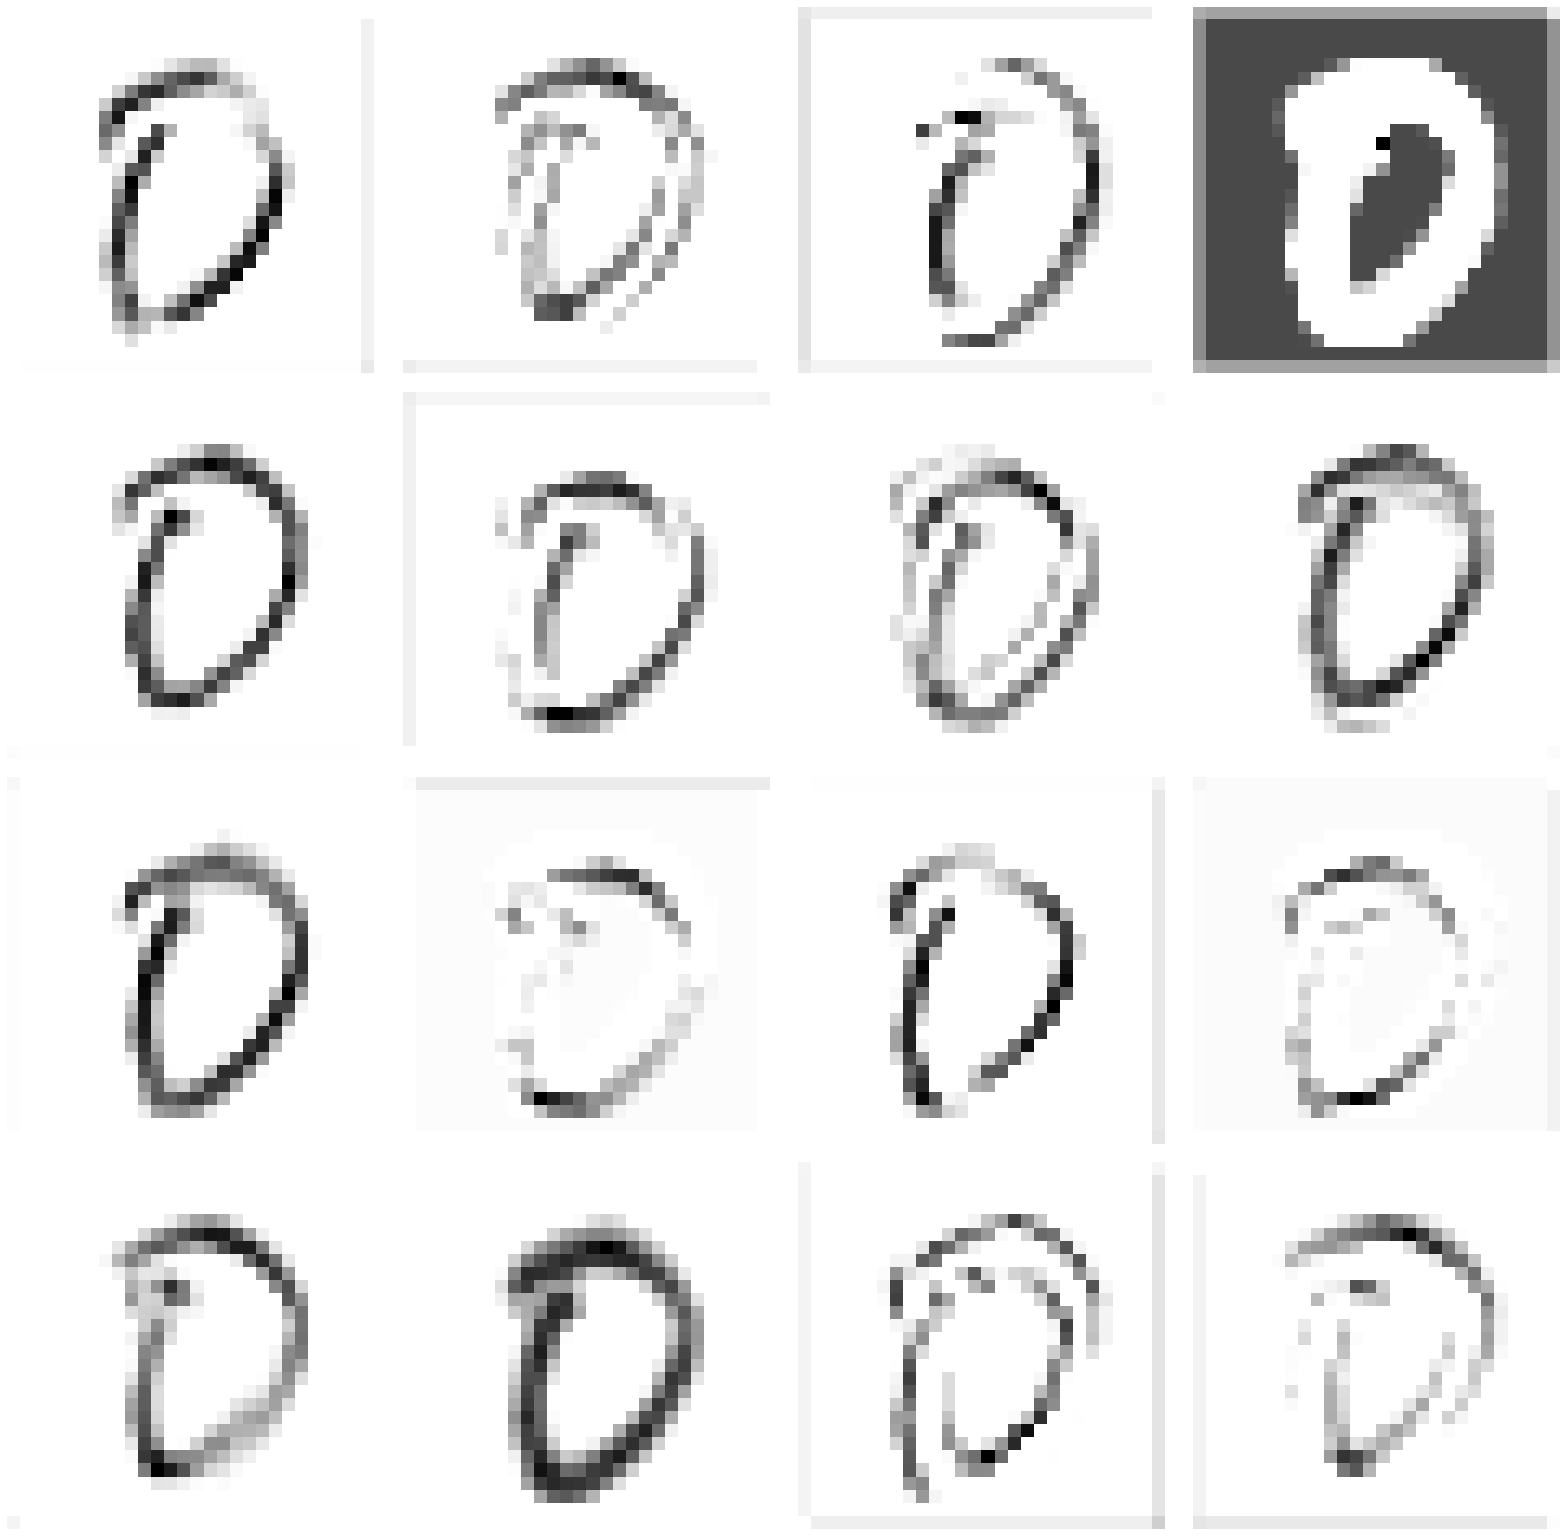

Mapa de características para el dígito 1
1/1 [==============================] - 0s 20ms/step


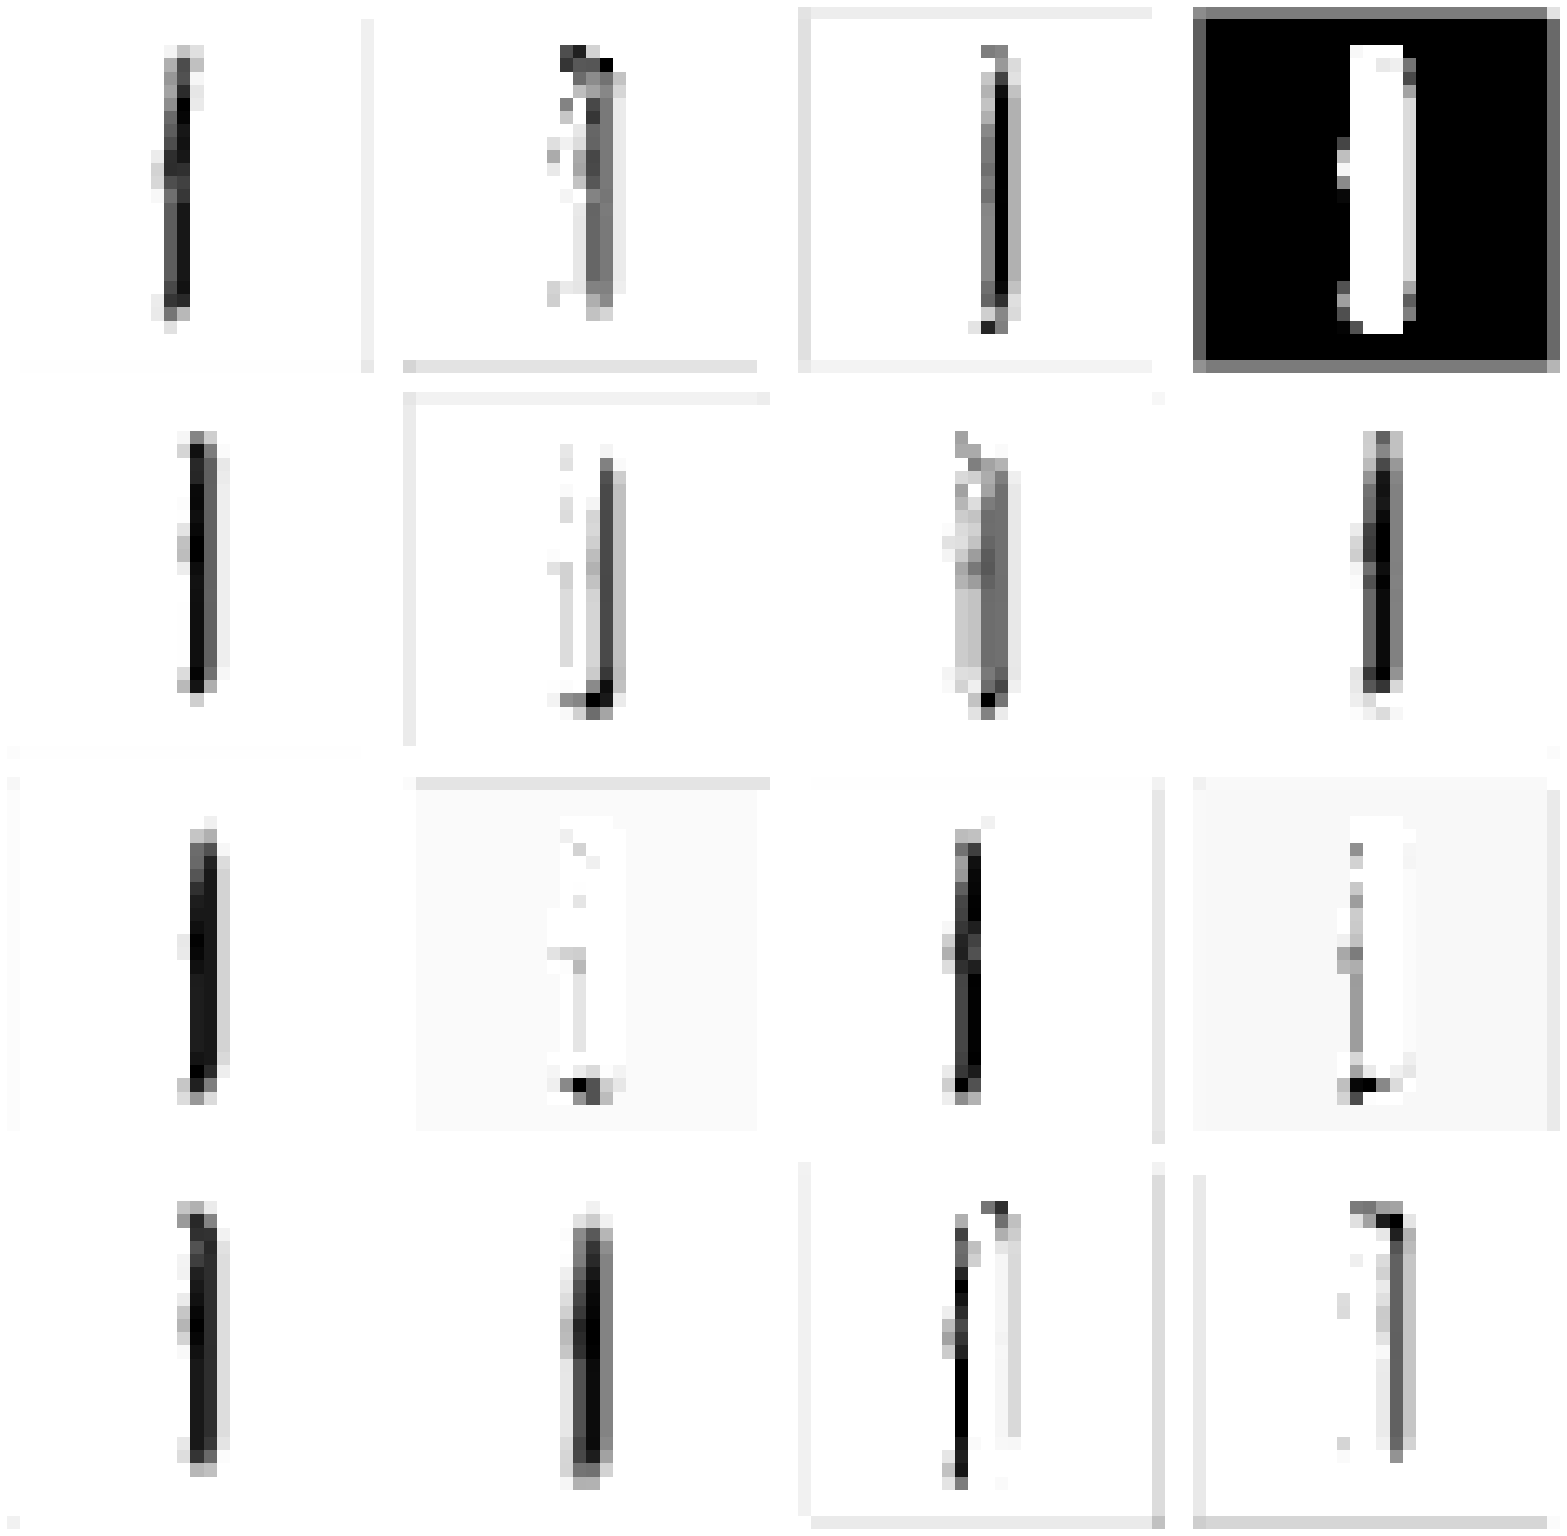

Mapa de características para el dígito 2
1/1 [==============================] - 0s 19ms/step


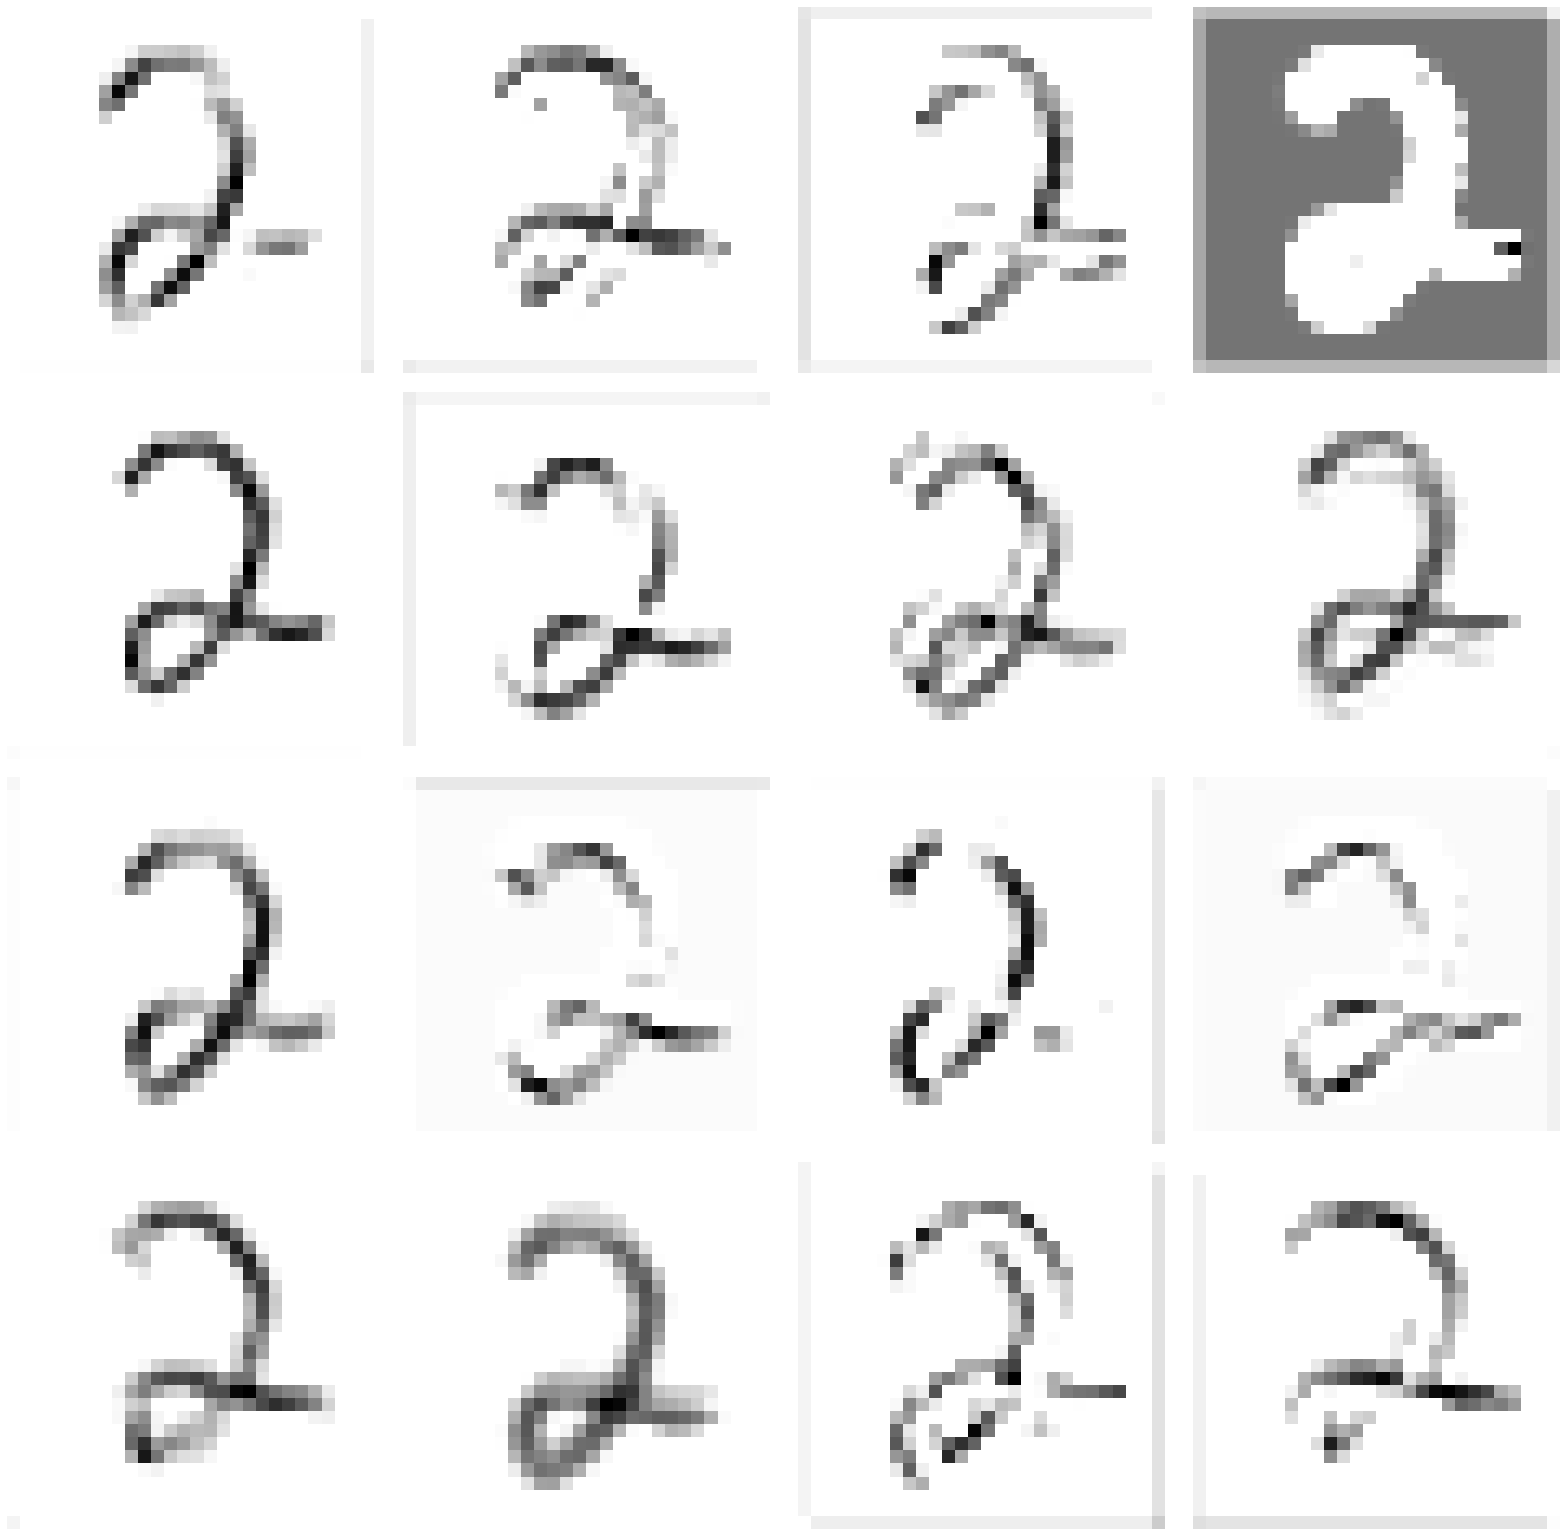

Mapa de características para el dígito 3
1/1 [==============================] - 0s 18ms/step


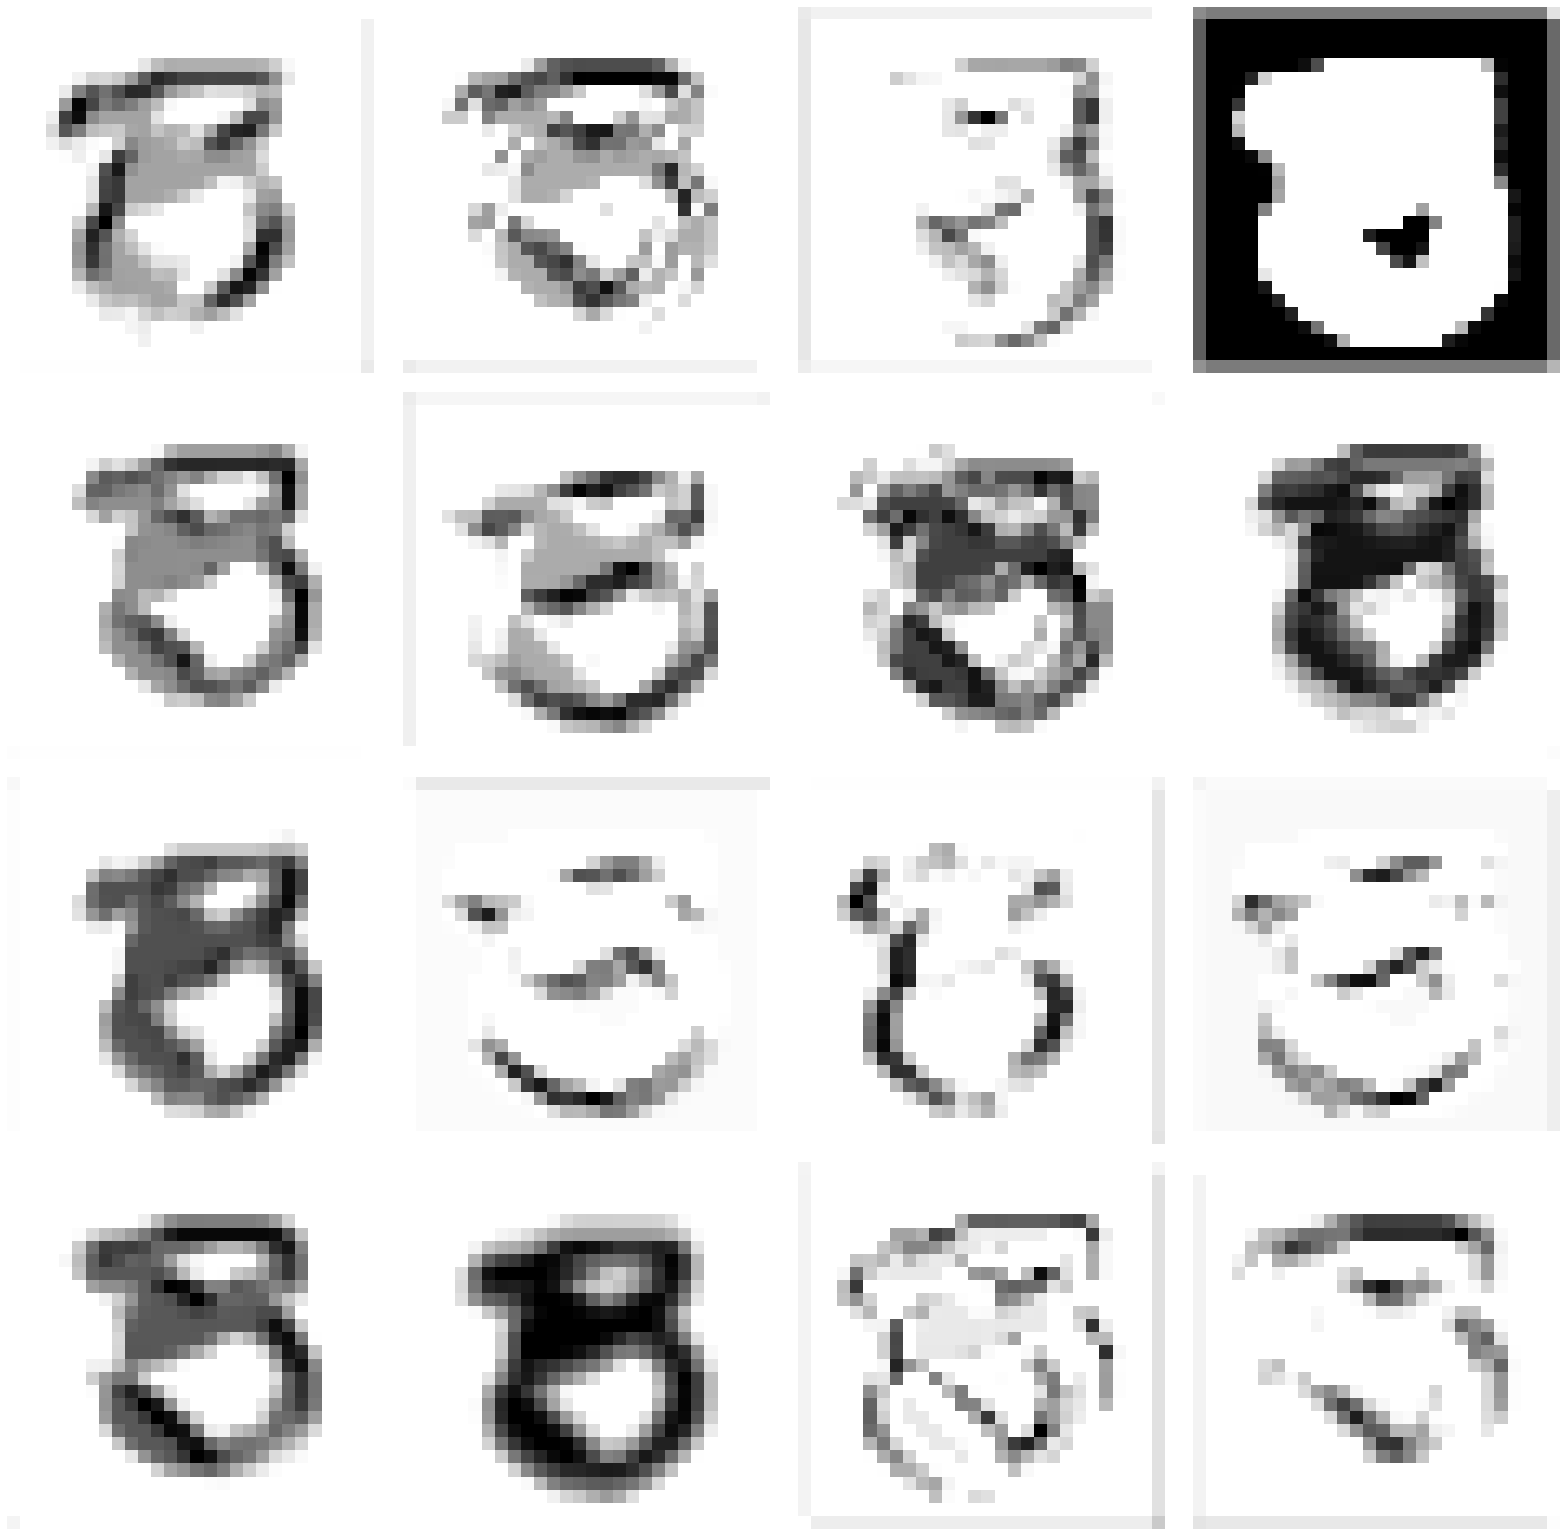

Mapa de características para el dígito 4
1/1 [==============================] - 0s 25ms/step


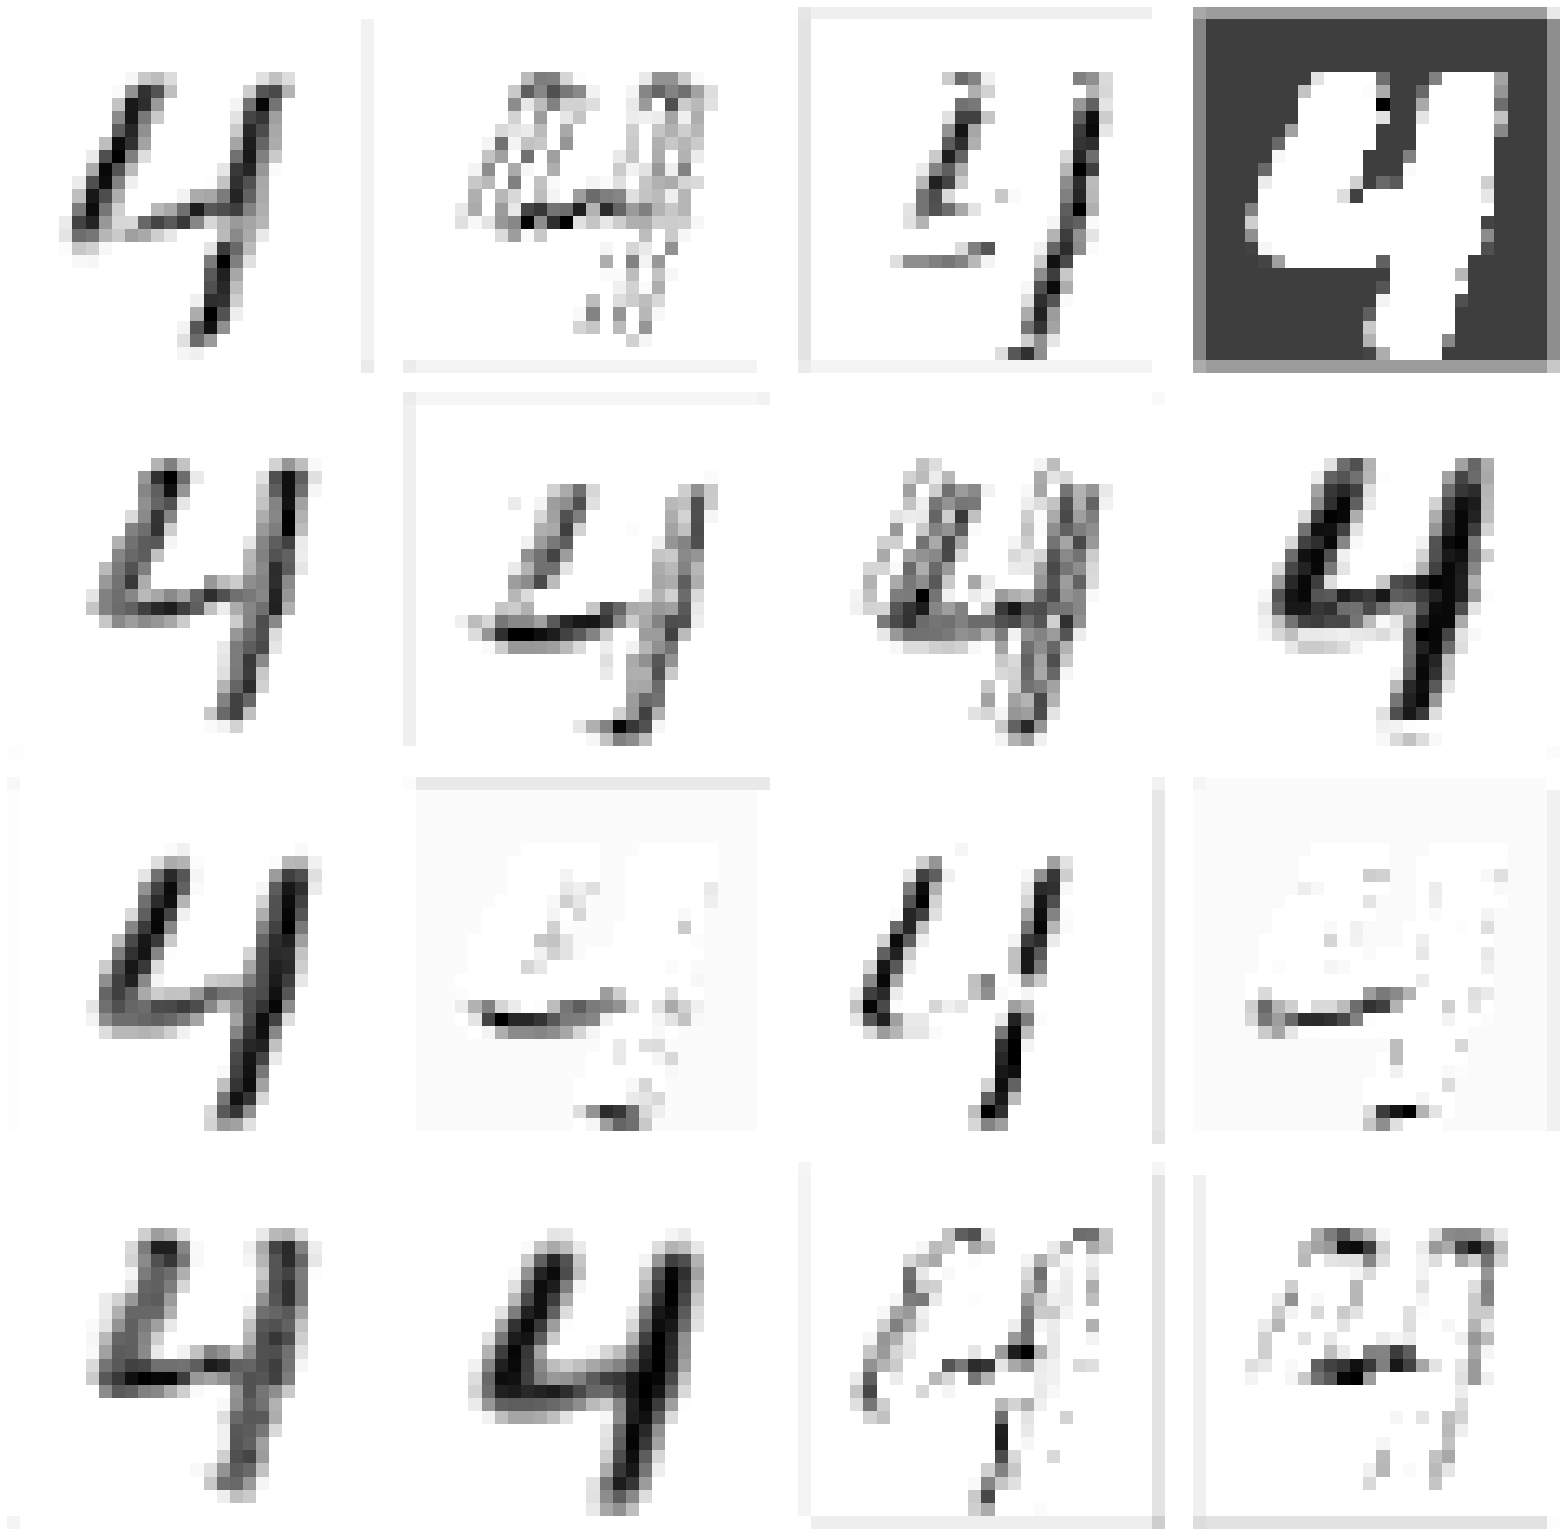

Mapa de características para el dígito 5
1/1 [==============================] - 0s 24ms/step


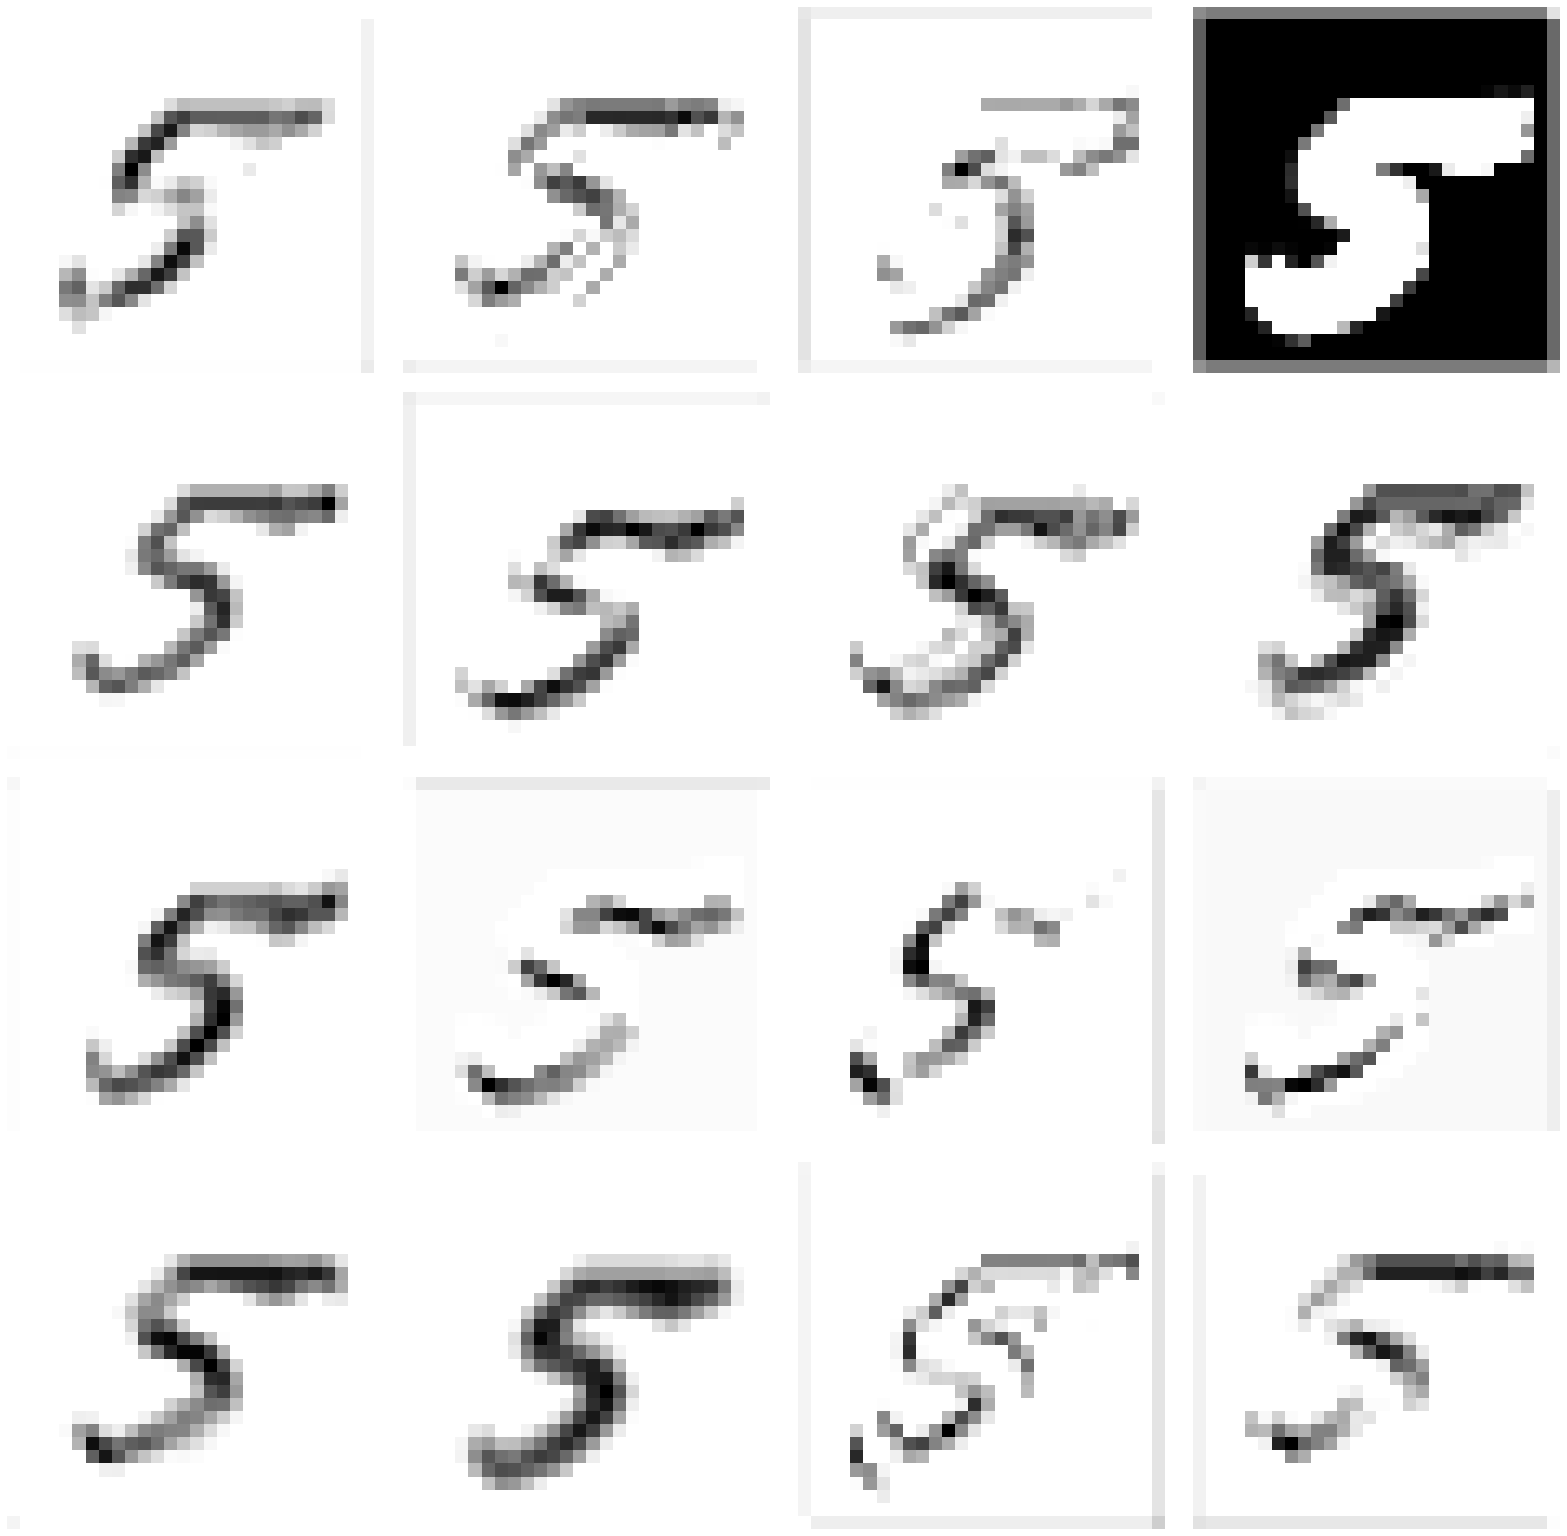

Mapa de características para el dígito 6
1/1 [==============================] - 0s 24ms/step


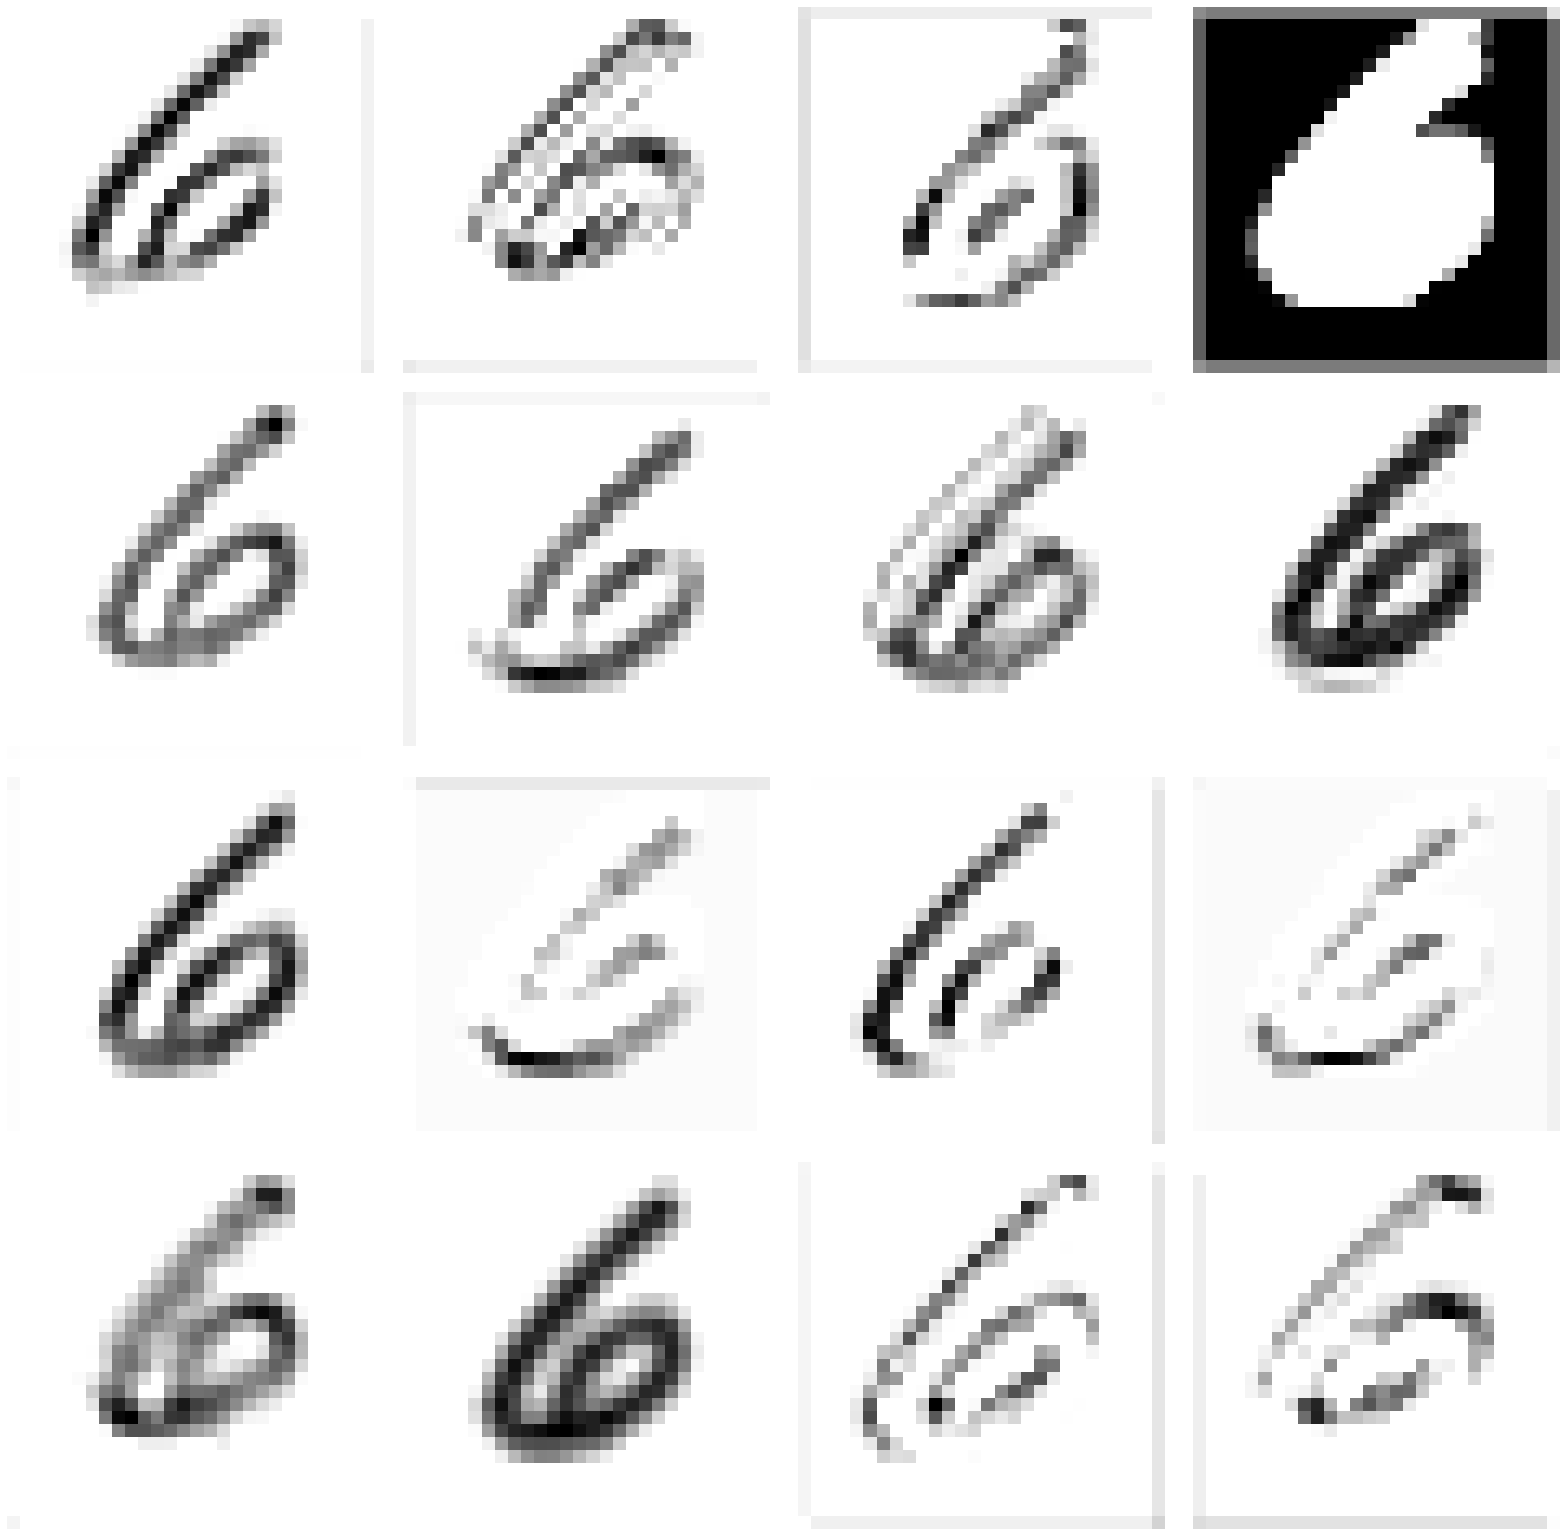

Mapa de características para el dígito 7
1/1 [==============================] - 0s 42ms/step


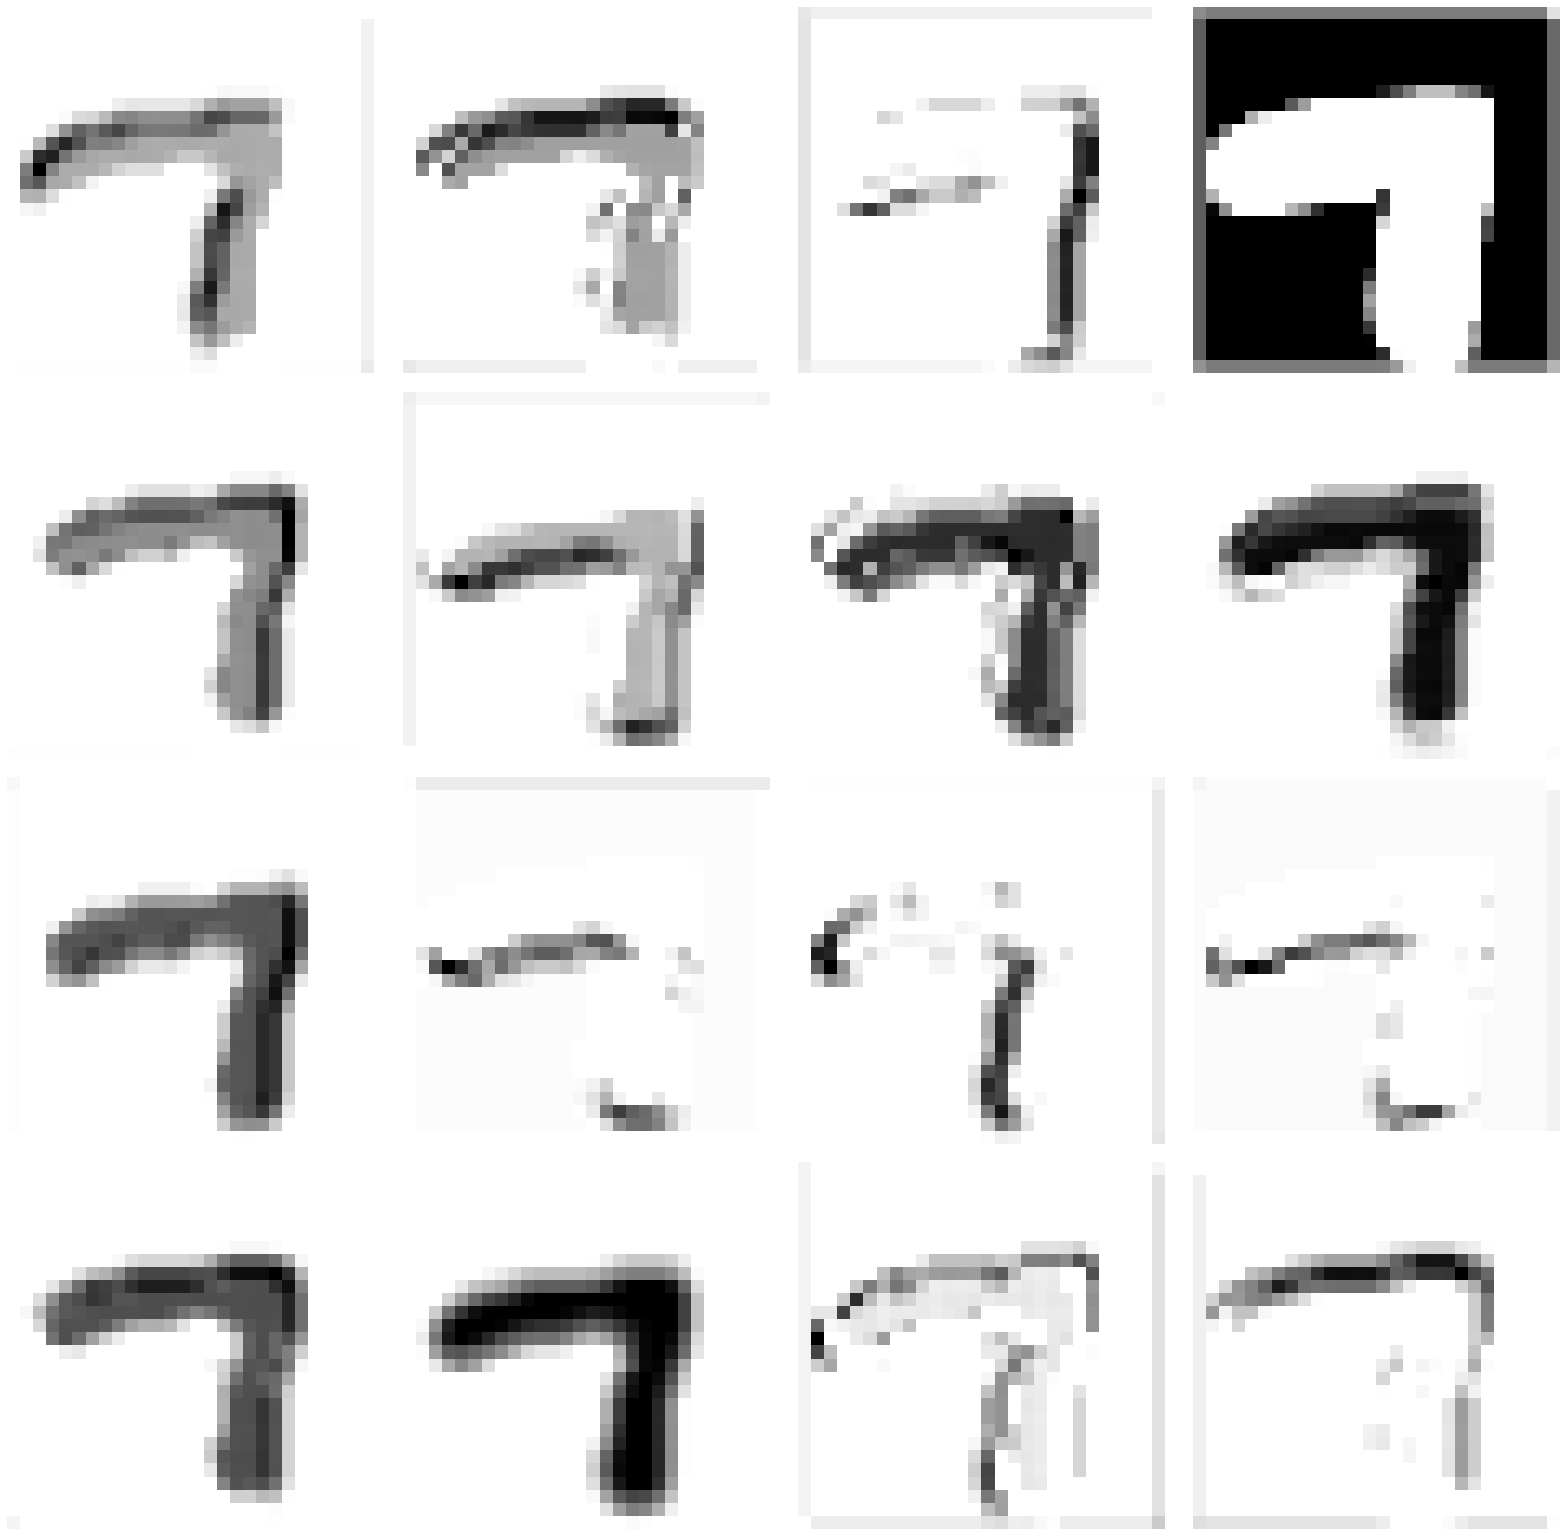

Mapa de características para el dígito 8
1/1 [==============================] - 0s 35ms/step


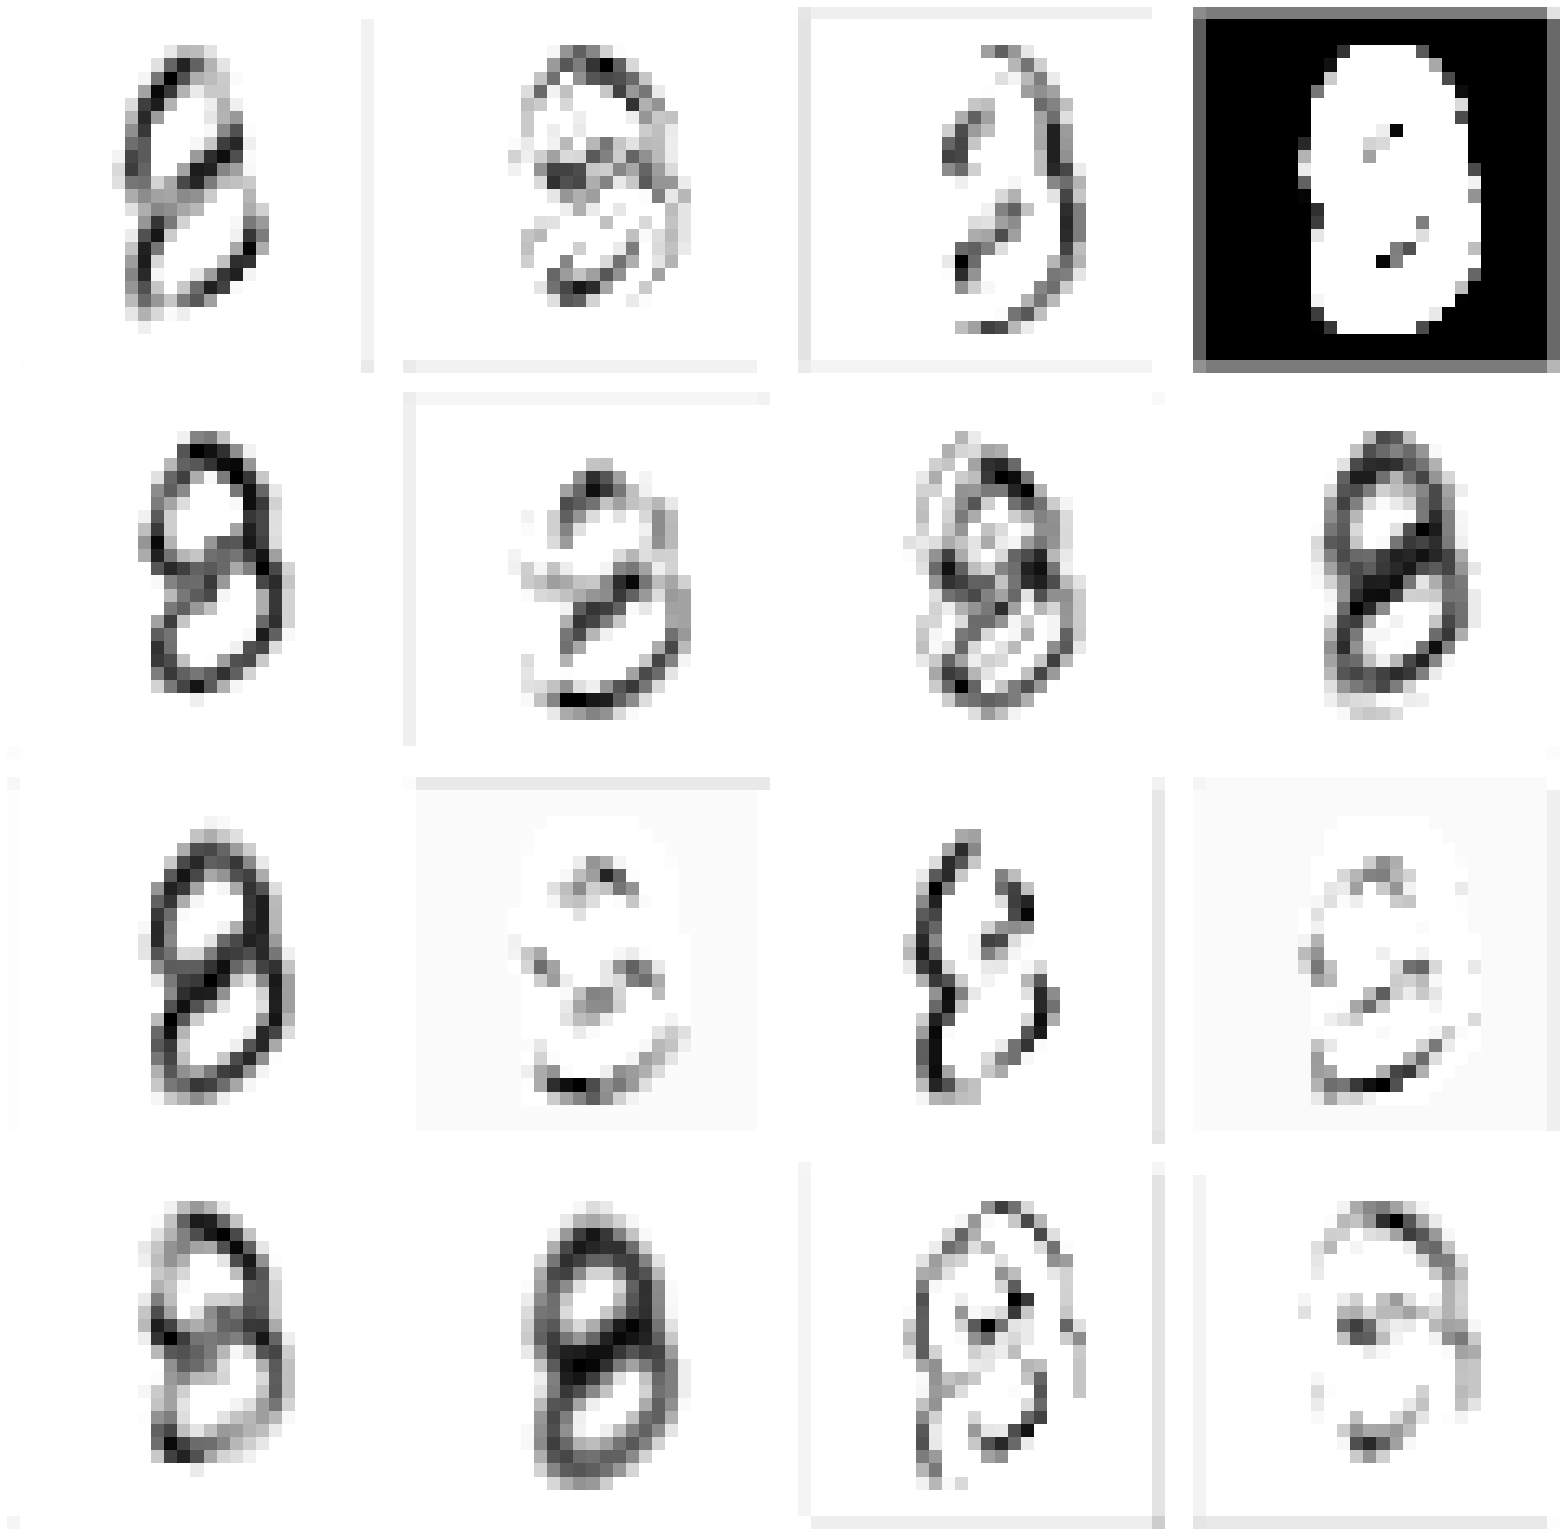

Mapa de características para el dígito 9
1/1 [==============================] - 0s 40ms/step


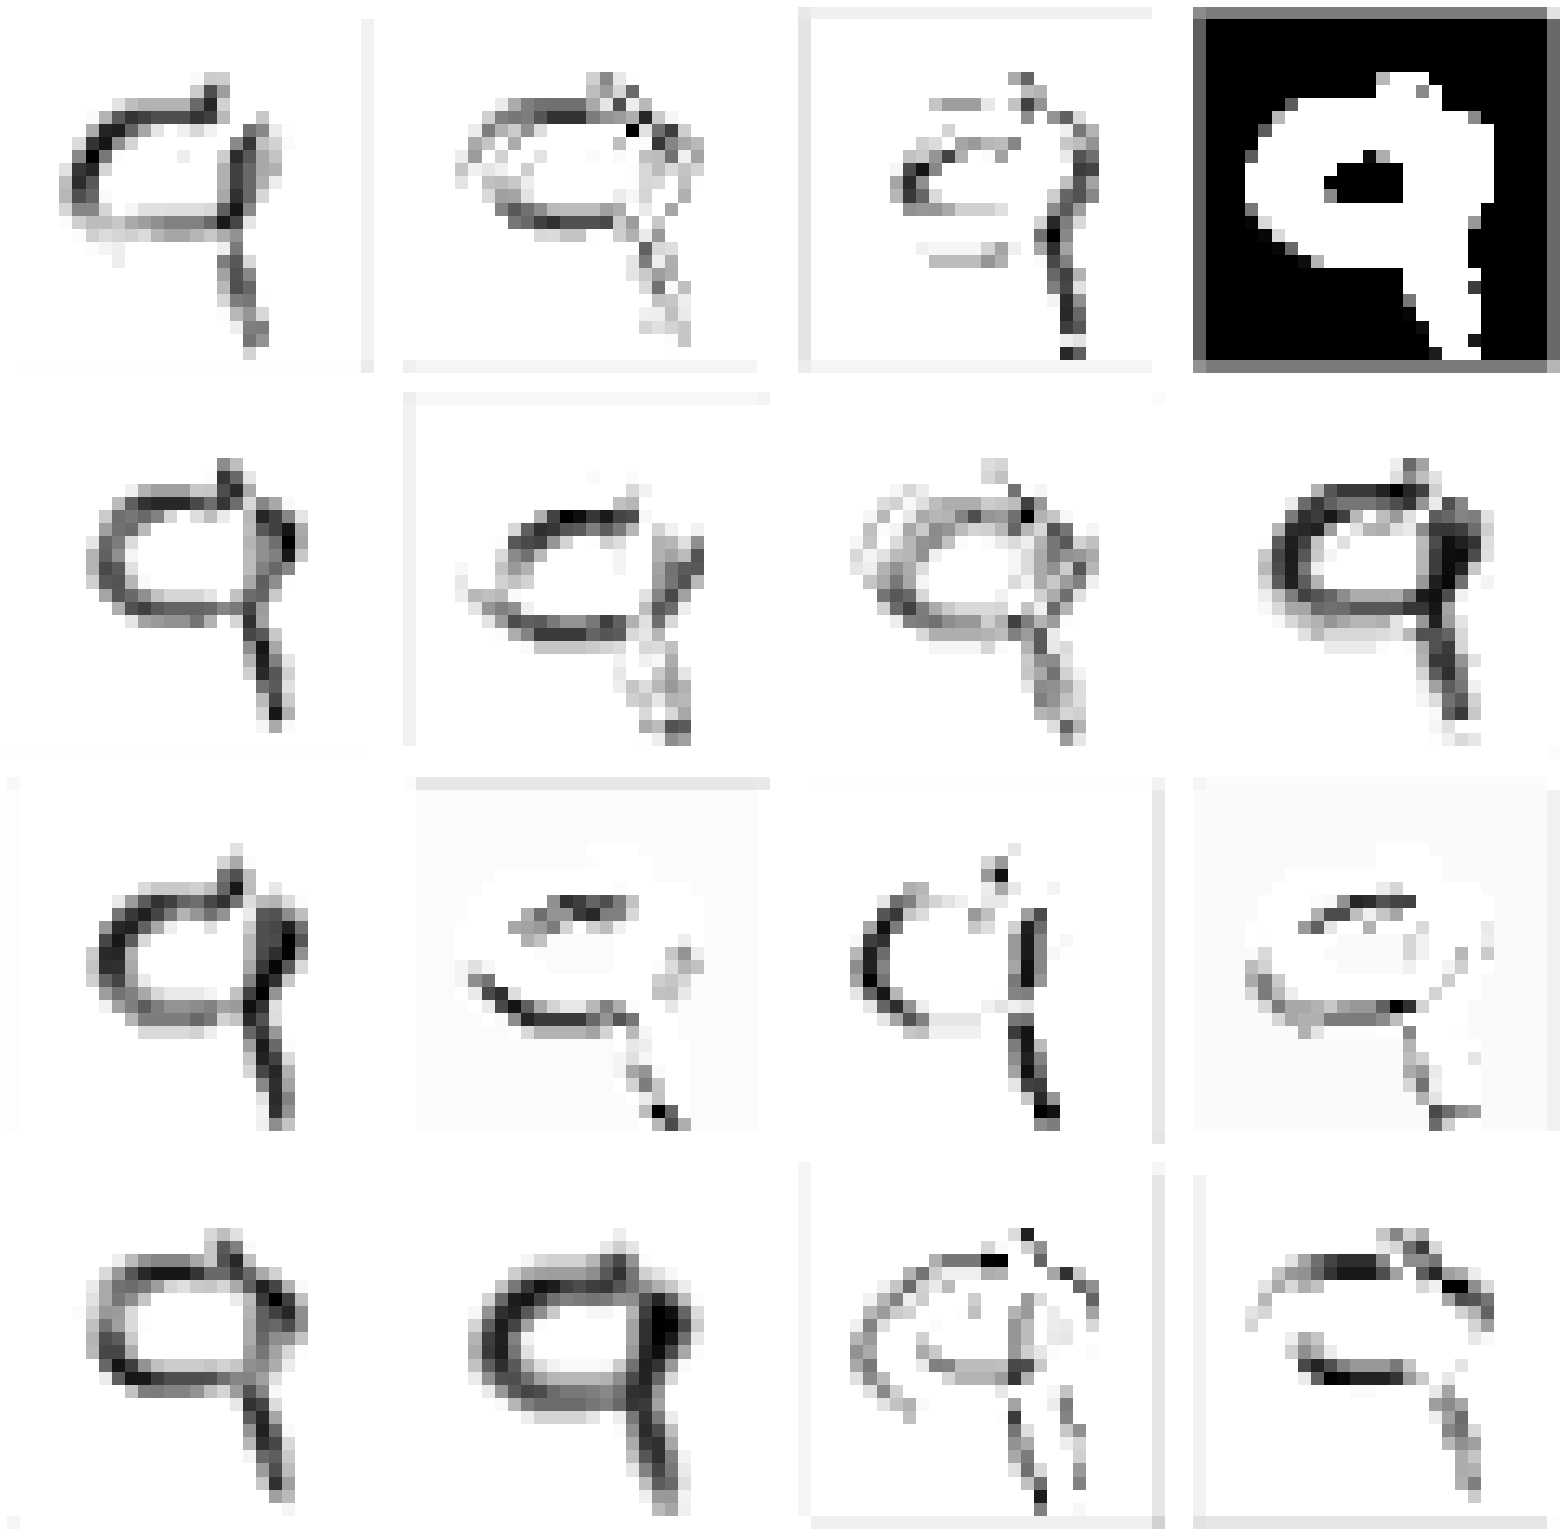

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Creamos un modelo que termina en la capa de convolución para obtener los mapas de características
input_layer = Input(shape=X_shape)
conv_layer = model.layers[0]
conv_output = conv_layer(input_layer)
feature_map_model = Model(inputs=input_layer, outputs=conv_output)

# Función para visualizar los mapas de características
def visualize_feature_maps(model, sample):
    # Obtenemos el mapa de características
    feature_maps = model.predict(sample[np.newaxis, ...])
    feature_maps = feature_maps[0]  # Obtenemos el resultado de la primera (única) capa de convolución
    
    # Visualizamos cada filtro
    num_filters = feature_maps.shape[-1]
    
    # Ajustamos la figura para visualizar los filtros
    fig, axes = plt.subplots(int(np.ceil(num_filters/4)), 
                             4, 
                             figsize=(feature_maps.shape[0], feature_maps.shape[1]))  
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    
    for i in range(num_filters):
        row = i // 4  # Filas
        col = i % 4   # Columnas
        axes[row, col].imshow(feature_maps[..., i], cmap='gray_r')
        axes[row, col].axis('off')
    
    #plt.tight_layout()
    plt.show()

# Seleccionamos un ejemplo de cada dígito del conjunto MNIST
for digit in range(10):
    idx = np.where(y_train_value == digit)[0][0]  # Tomamos el primer ejemplo de cada dígito
    sample = X_train[idx]
    
    print(f"Mapa de características para el dígito {digit}")
    visualize_feature_maps(feature_map_model, sample)


Los experimentos con MNIST son interesantes y, sobre todo, son livianos de ejecutar, pero representan un problema quizá demasiado simple, con poca variabilidad respecto a las imágenes que estamos procesando. Además, al ser en blanco y negro, cada imagen se reduce a una única matriz y no se aprovecha la capacidad de procesar múltiples canales. Ya tuvimos la oportunidad de trabajar con imágenes a color en el contexto de nuestra propia ANN sin librerías, y vimos que las redes de convolución logran aprovechar los tres canales RGB (rojo, verde, azul).

<b>Pongámosle Color</b>

Usaremos imágenes de perros y gatos en los siguientes experimentos.

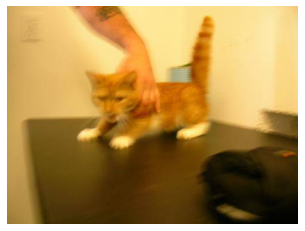

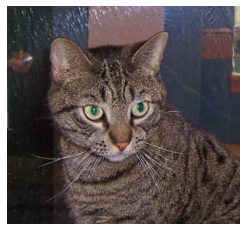

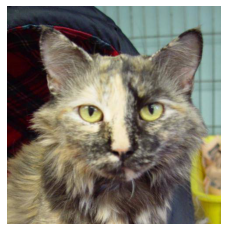

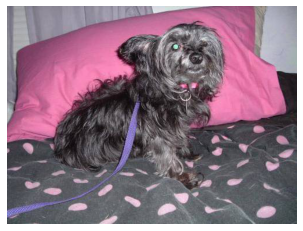

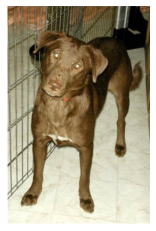

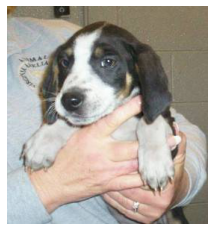

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Descargar el dataset
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
dataset = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=url, extract=True)

# Directorio de las imágenes
import os
base_dir = os.path.join(os.path.dirname(dataset), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Obteniendo la lista de imágenes de gatos y perros
cat_images = os.listdir(train_cats_dir)
dog_images = os.listdir(train_dogs_dir)

# Función para visualizar las imágenes
def show_image(img_path):
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Mostrar algunos gatos y un perros
show_image(os.path.join(train_cats_dir, cat_images[0]))
show_image(os.path.join(train_cats_dir, cat_images[1]))
show_image(os.path.join(train_cats_dir, cat_images[2]))
show_image(os.path.join(train_dogs_dir, dog_images[0]))
show_image(os.path.join(train_dogs_dir, dog_images[1]))
show_image(os.path.join(train_dogs_dir, dog_images[2]))

Usaremos tres capas de convolución, con 16 kernels en cada una, aunque de distintos tamaños. Alternaremos las capas de convolución con capas de Pooling, para ir reduciendo el tamaño de la representación. Completaremos con una capa densa, previa a la salida, que será sigmoidal, mientras que el resto de las activaciones serán del tipo ReLU.

En esta ocasión no vamos a buscar una mejor configuración de hiperparámetros, tampoco vamos a mejorar el modelo con regularización, ni siquiera lo vamos a entrenar lo suficiente. Solo queremos demostrar que la CNN es capaz de clasificar perros y gatos mejor que el azar, lo que es una señal de que está aprendiendo.

In [7]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Definir rutas de los directorios de datos
base_dir = os.path.join(os.path.dirname(dataset), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'validation')  

# Función para cargar imágenes y etiquetas de un directorio
def load_images_and_labels(directory, label_map, target_size=(150, 150)):
    images = []
    labels = []
    for label, label_id in label_map.items():
        class_dir = os.path.join(directory, label)
        for img_path in os.listdir(class_dir):
            img = load_img(os.path.join(class_dir, img_path), target_size=target_size)
            images.append(img_to_array(img))
            labels.append(label_id)
    return np.array(images), np.array(labels)

# Cargar imágenes y etiquetas
label_map = {'cats': 0, 'dogs': 1}
X_train, y_train = load_images_and_labels(train_dir, label_map)
X_test, y_test = load_images_and_labels(test_dir, label_map)

# Estandarización manual
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Convertir etiquetas a categóricas
y_train_value = y_train
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Detectemos el tamaño de las grillas
# X_train[0] es la cantidad de imagenes. 
input_shape = X_train[0].shape

# Creamos la CNN con dos capas de convolución 
model = Sequential()
model.add(layers.Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=input_shape)) # La imagen a color tiene 3 canales
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (4, 4), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())

# Dese acá es una red neuronal fully connected, como ya conocíamos.
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))


# Compilamos el modelo indicando la función de perdida, optimizador y métricas.
# vamos a usar Entropía Categórica, ADAM y Exactitud de clasificación, respectivamente. 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamos el modelo con los datos de entrenamiento
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Evaluamos el modelo con datos de testeo
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy:', accuracy)

Epoch 1/20
63/63 [==============================] - 15s 225ms/step - loss: 0.7105 - accuracy: 0.5655
Epoch 2/20
63/63 [==============================] - 15s 230ms/step - loss: 0.6340 - accuracy: 0.6310
Epoch 3/20
63/63 [==============================] - 17s 269ms/step - loss: 0.5906 - accuracy: 0.6845
Epoch 4/20
63/63 [==============================] - 18s 286ms/step - loss: 0.5399 - accuracy: 0.7200
Epoch 5/20
63/63 [==============================] - 18s 288ms/step - loss: 0.4525 - accuracy: 0.7970
Epoch 6/20
63/63 [==============================] - 18s 287ms/step - loss: 0.3973 - accuracy: 0.8265
Epoch 7/20
63/63 [==============================] - 19s 294ms/step - loss: 0.3259 - accuracy: 0.8570
Epoch 8/20
63/63 [==============================] - 19s 294ms/step - loss: 0.2044 - accuracy: 0.9240
Epoch 9/20
63/63 [==============================] - 19s 302ms/step - loss: 0.1220 - accuracy: 0.9545
Epoch 10/20
63/63 [==============================] - 18s 287ms/step - loss: 0.1087 - accura

Considerando que estamos ante una clasificación binaria balanceada, un modelo tonto lograría alrededor del 50% de exactitud. El hecho de que estemos en el orden del 70% de éxito es probablemente suficiente para afirmar que la red ha aprendido a reconocer perros y gatos mejor que el azar. Si además consideramos que solo se ha entrenado durante 20 epochs y no se está utilizando ningún tipo de regularización, podemos suponer que se pueden lograr resultados significativamente mejores.

Sin embargo, buscar un mejor clasificador no es el foco de nuestros experimentos en esta clase. Queremos seguir dilucidando qué significa para una CNN aprender, comenzando por observar los mapas de características que se obtienen al procesar imágenes de gatos, aprovechando el modelo que acabamos de entrenar.

A continuación, se muestran 10 fotos de gatos... ¡que las disfrute!

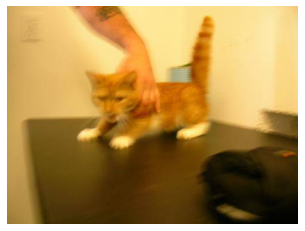

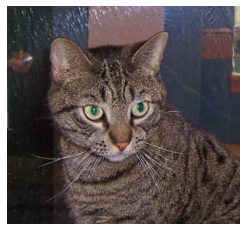

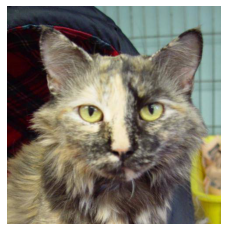

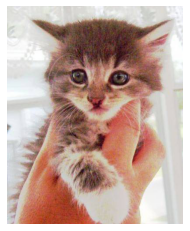

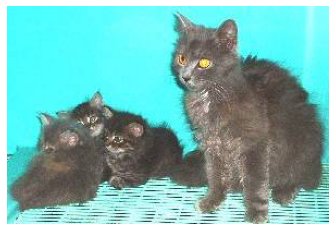

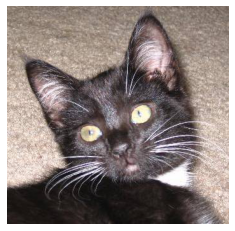

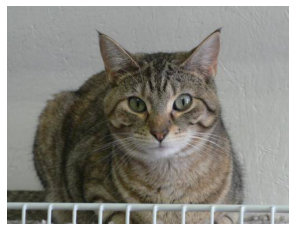

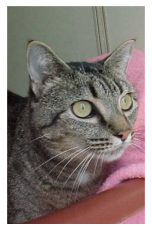

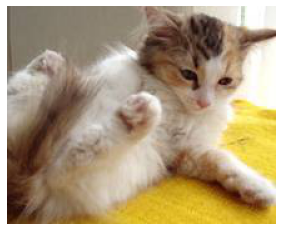

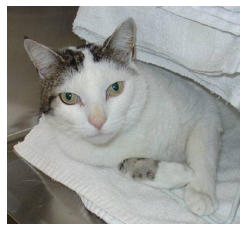

In [8]:
for i in range(10):
    show_image(os.path.join(train_cats_dir, cat_images[i]))

Veamos cómo las mismas fotos se transforman en mapas de características a la salida de la capa de convolución. Como hay 16 kernels, obtenemos 16 mapas. Vamos a visualizar la salida para solo uno de los tres canales de color; podríamos hacer lo mismo con los otros dos canales, pero no es relevante en este experimento. Cada mapa de características se visualiza en blanco y negro, ya que corresponde a la transformación de solo un canal de color.

A continuación, se presentan los mapas de características a la salida de la primera capa de convolución.

Mapa de características para la imagen 0
1/1 [==============================] - 0s 78ms/step


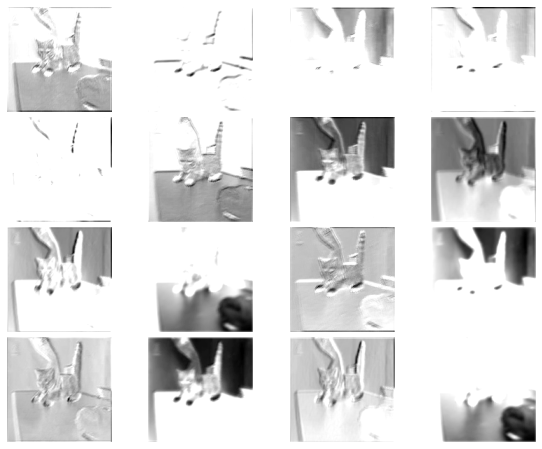

Mapa de características para la imagen 1
1/1 [==============================] - 0s 23ms/step


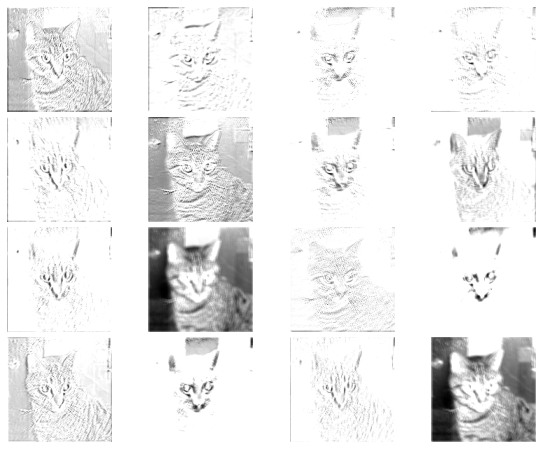

Mapa de características para la imagen 2
1/1 [==============================] - 0s 21ms/step


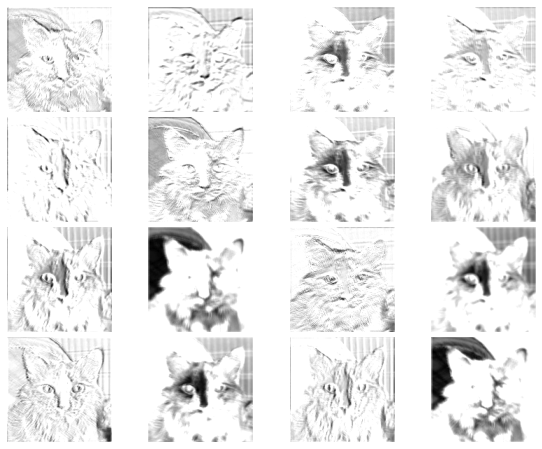

Mapa de características para la imagen 3
1/1 [==============================] - 0s 33ms/step


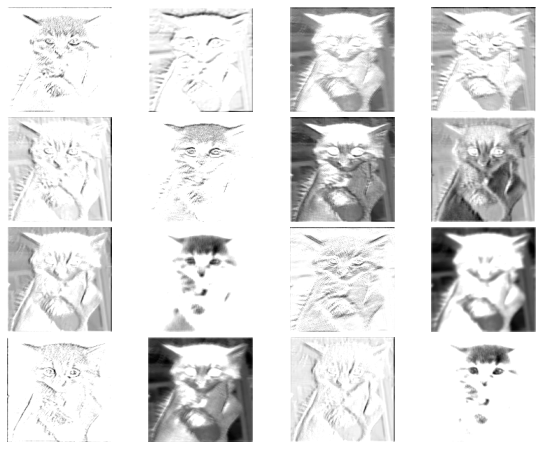

Mapa de características para la imagen 4
1/1 [==============================] - 0s 20ms/step


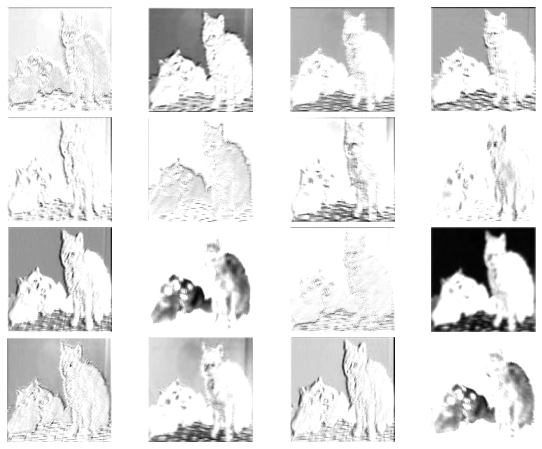

Mapa de características para la imagen 5
1/1 [==============================] - 0s 23ms/step


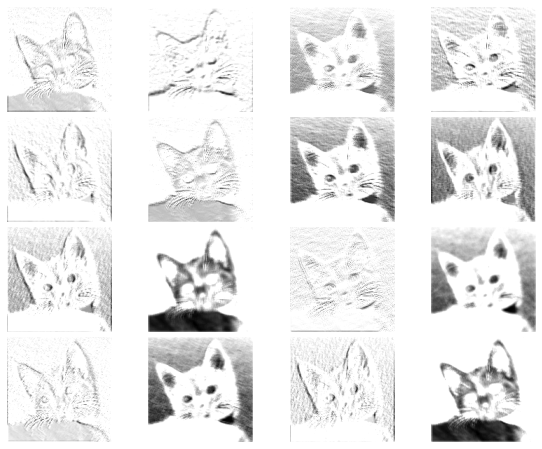

Mapa de características para la imagen 6
1/1 [==============================] - 0s 25ms/step


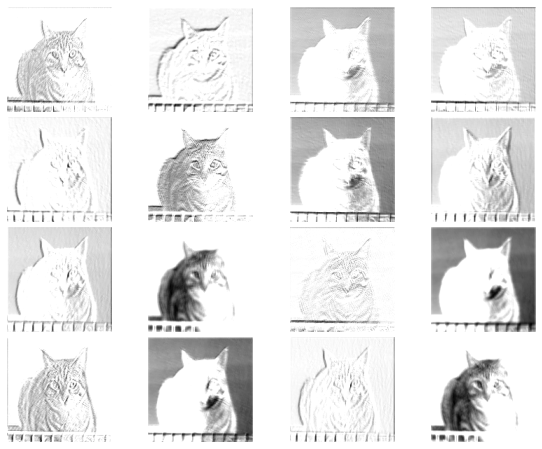

Mapa de características para la imagen 7
1/1 [==============================] - 0s 23ms/step


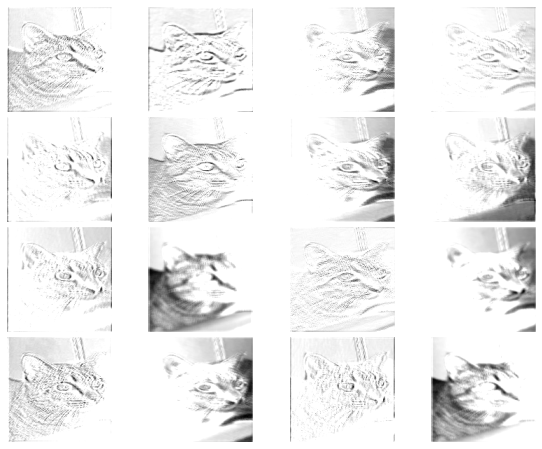

Mapa de características para la imagen 8
1/1 [==============================] - 0s 24ms/step


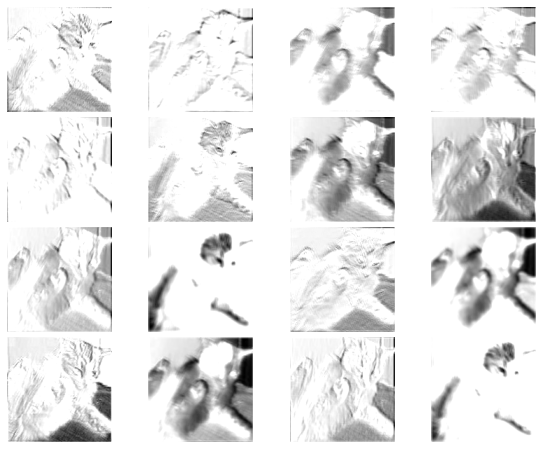

Mapa de características para la imagen 9
1/1 [==============================] - 0s 27ms/step


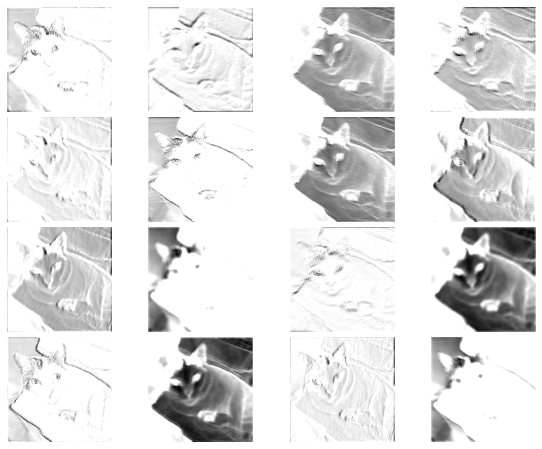

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model

# Creamos un modelo que termina en la primera capa de convolución para obtener los mapas de características
input_layer = Input(shape=input_shape)
conv_layer = model.layers[0]
conv_output = conv_layer(input_layer)
feature_map_model = Model(inputs=input_layer, outputs=conv_output)

# Función para visualizar los mapas de características
def visualize_feature_maps(model, sample):
    # Obtenemos el mapa de características
    feature_maps = model.predict(sample[np.newaxis, ...])
    feature_maps = feature_maps[0]  # Obtenemos el resultado del primer canal
    
    # Visualizamos cada filtro
    num_filters = feature_maps.shape[-1]
    feature_map_height = feature_maps.shape[1]
    feature_map_width = feature_maps.shape[2]
    
    # Ajustamos la figura para visualizar los filtros, con 4 columnas
    fig, axes = plt.subplots(int(np.ceil(num_filters / 4)), 
                             4, 
                             figsize=(10, int(np.ceil(num_filters / 4)) * 2))  
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    
    for i in range(num_filters):
        row = i // 4  # Filas
        col = i % 4   # Columnas
        axes[row, col].imshow(feature_maps[..., i], cmap='gray_r')  
        axes[row, col].axis('off')  
    
    plt.show()

# Ejemplo de uso para un conjunto de imágenes
for i in range(10):
    sample = X_train[i]  
    print(f"Mapa de características para la imagen {i}")
    visualize_feature_maps(feature_map_model, sample)


Estos mapas de características ingresan a la siguiente capa de convolución, donde otros filtros los vuelven a procesar. En rigor, hay 16 nuevos mapas por cada mapa que ingresó, es decir, el número de mapas va creciendo. Aquí solo estamos presentando la salida que correspondería a los 16 nuevos mapas para uno de los mapas que ingresó de la capa previa, pero es suficiente para darnos una idea del proceso.

Mapa de características para la imagen 0
1/1 [==============================] - 0s 51ms/step


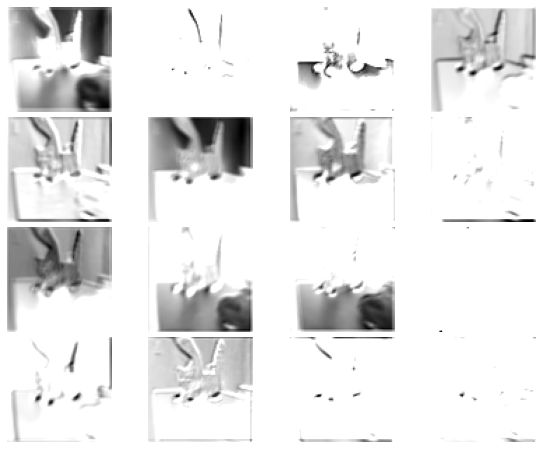

Mapa de características para la imagen 1
1/1 [==============================] - 0s 32ms/step


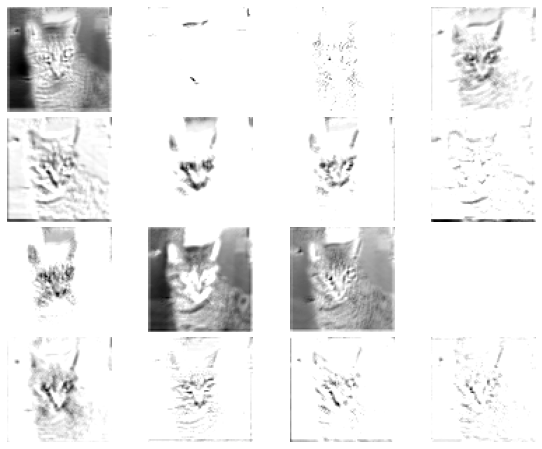

Mapa de características para la imagen 2
1/1 [==============================] - 0s 24ms/step


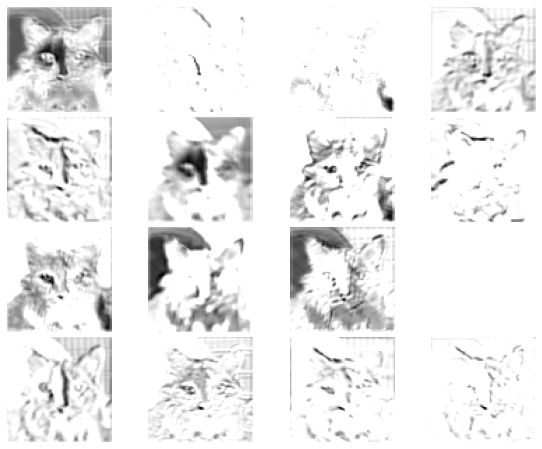

Mapa de características para la imagen 3
1/1 [==============================] - 0s 23ms/step


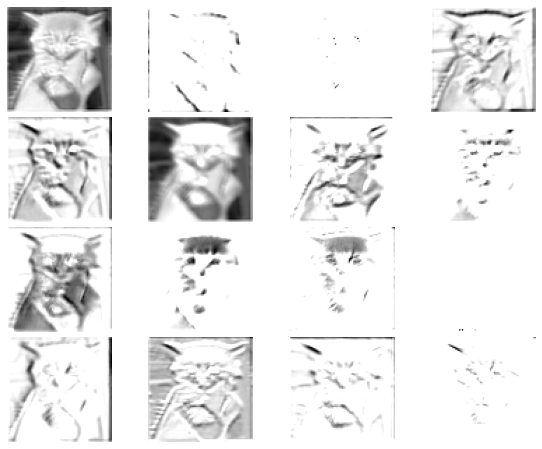

Mapa de características para la imagen 4
1/1 [==============================] - 0s 25ms/step


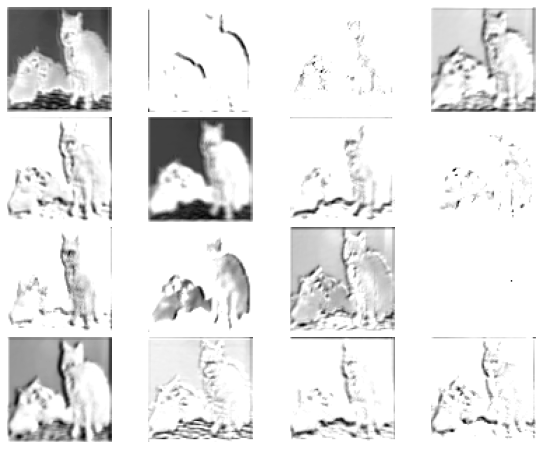

Mapa de características para la imagen 5
1/1 [==============================] - 0s 25ms/step


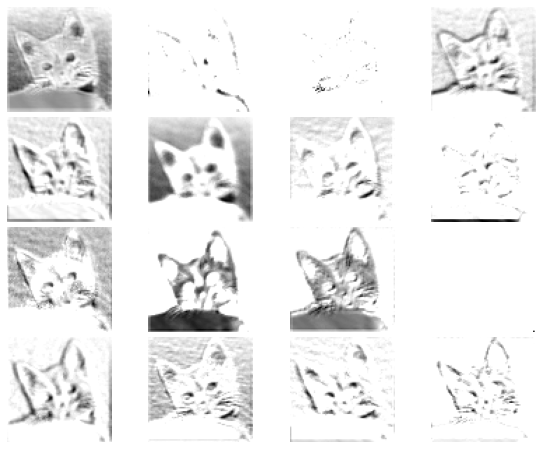

Mapa de características para la imagen 6
1/1 [==============================] - 0s 28ms/step


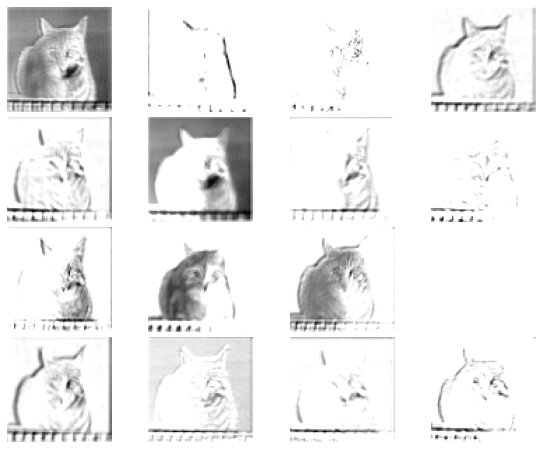

Mapa de características para la imagen 7
1/1 [==============================] - 0s 47ms/step


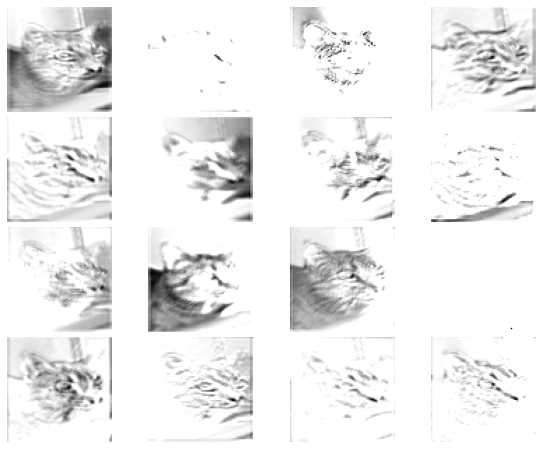

Mapa de características para la imagen 8
1/1 [==============================] - 0s 21ms/step


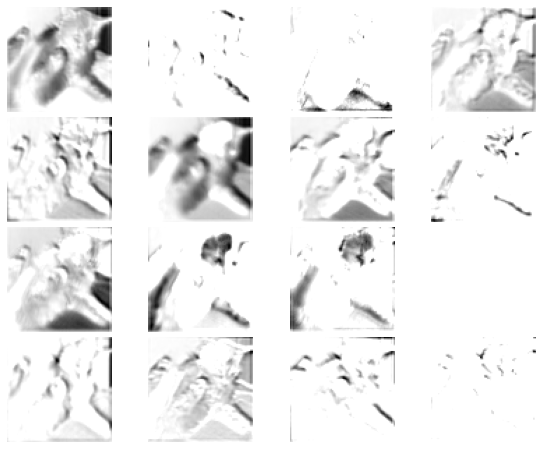

Mapa de características para la imagen 9
1/1 [==============================] - 0s 28ms/step


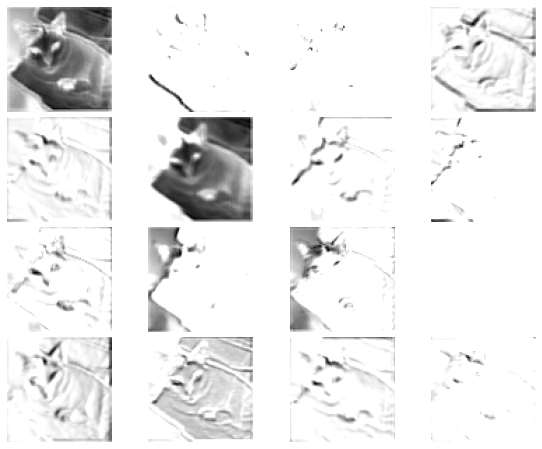

In [10]:
# Creamos un modelo que termina en la segunda capa de convolución para obtener los mapas de características
input_layer = Input(shape=input_shape)
x = model.layers[0](input_layer)
x = model.layers[1](x)
conv_output = model.layers[2](x) # Segunda Capa de Convolución
feature_map_model = Model(inputs=input_layer, outputs=conv_output)

# Función para visualizar los mapas de características
def visualize_feature_maps(model, sample):
    # Obtenemos el mapa de características
    feature_maps = model.predict(sample[np.newaxis, ...])
    feature_maps = feature_maps[0]  # Obtenemos el resultado del primer canal
    
    # Visualizamos cada filtro
    num_filters = feature_maps.shape[-1]
    feature_map_height = feature_maps.shape[1]
    feature_map_width = feature_maps.shape[2]
    
    # Ajustamos la figura para visualizar los filtros, con 4 columnas
    fig, axes = plt.subplots(int(np.ceil(num_filters / 4)), 
                             4, 
                             figsize=(10, int(np.ceil(num_filters / 4)) * 2))  
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    
    for i in range(num_filters):
        row = i // 4  # Filas
        col = i % 4   # Columnas
        axes[row, col].imshow(feature_maps[..., i], cmap='gray_r')  
        axes[row, col].axis('off')  
    
    plt.show()

# Ejemplo de uso para un conjunto de imágenes
for i in range(10):
    sample = X_train[i]  
    print(f"Mapa de características para la imagen {i}")
    visualize_feature_maps(feature_map_model, sample)

Los mapas de características avanzan a la tercera capa, y en cada salida se van aislando atributos más específicos para la identificación de la imagen. Aunque para nosotros pueda parecer que la imagen se vuelve más difícil de interpretar, para la red neuronal esto significa una mayor capacidad para distinguir patrones cada vez más abstractos y complejos. En las primeras capas, la red identifica características de bajo nivel, como bordes o colores, pero a medida que avanza a capas más profundas, comienza a identificar formas, texturas y relaciones espaciales más específicas, que son esenciales para reconocer objetos más complejos. En teoría, es esta jerarquía de patrones lo que permite a la red comprender la imagen a un nivel más alto, facilitando la clasificación o detección de objetos en la fase final.

Mapa de características para la imagen 0
1/1 [==============================] - 0s 56ms/step


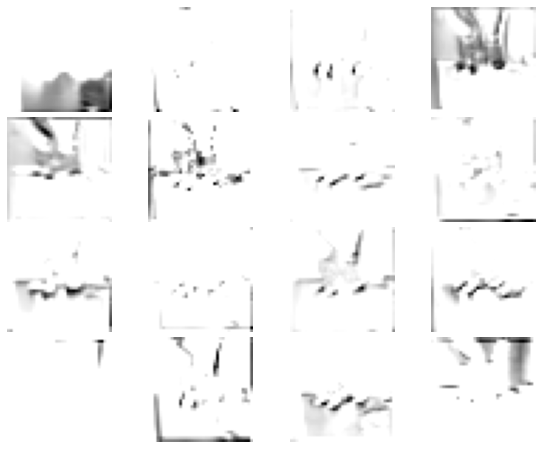

Mapa de características para la imagen 1
1/1 [==============================] - 0s 23ms/step


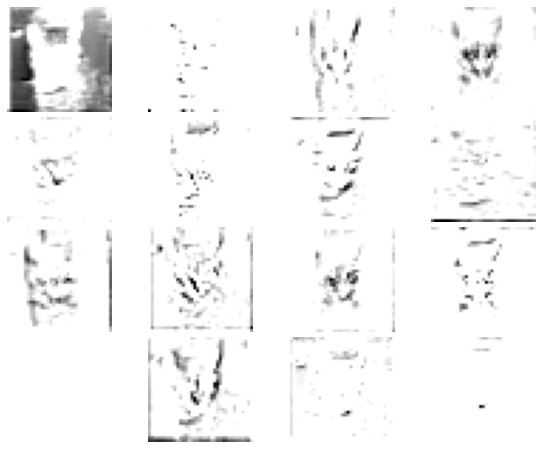

Mapa de características para la imagen 2
1/1 [==============================] - 0s 33ms/step


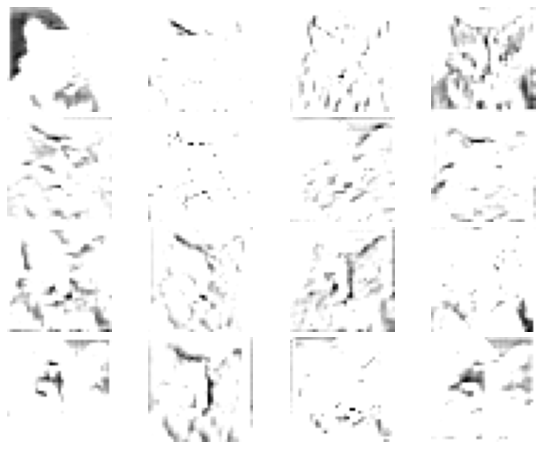

Mapa de características para la imagen 3
1/1 [==============================] - 0s 24ms/step


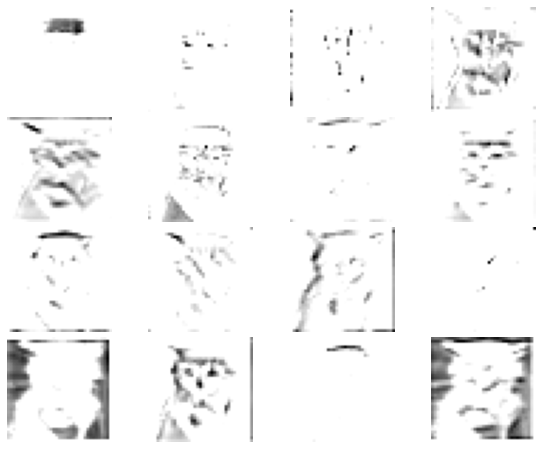

Mapa de características para la imagen 4
1/1 [==============================] - 0s 23ms/step


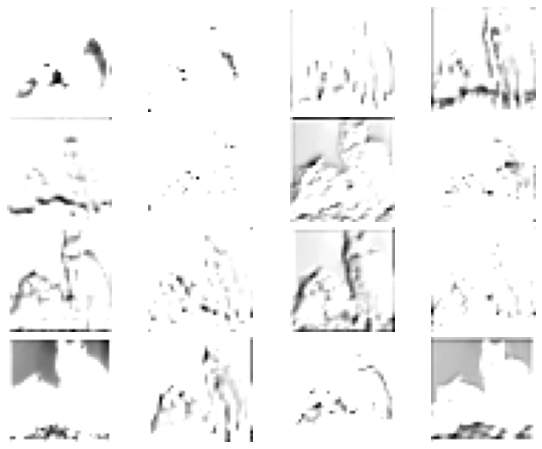

Mapa de características para la imagen 5
1/1 [==============================] - 0s 27ms/step


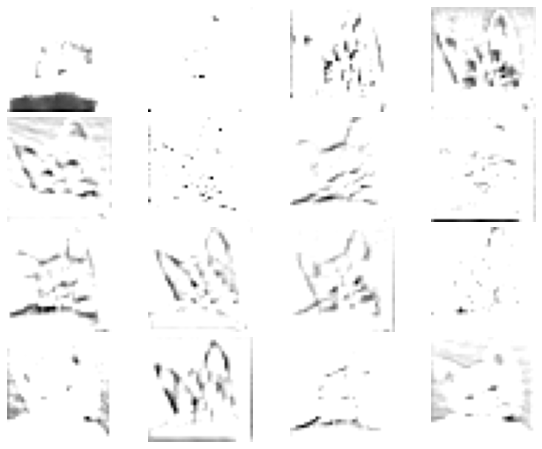

Mapa de características para la imagen 6
1/1 [==============================] - 0s 25ms/step


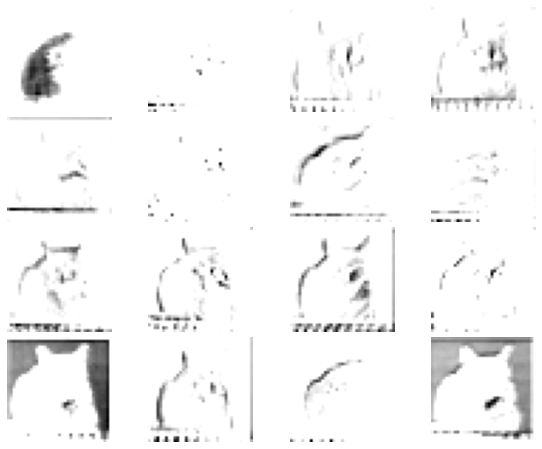

Mapa de características para la imagen 7
1/1 [==============================] - 0s 36ms/step


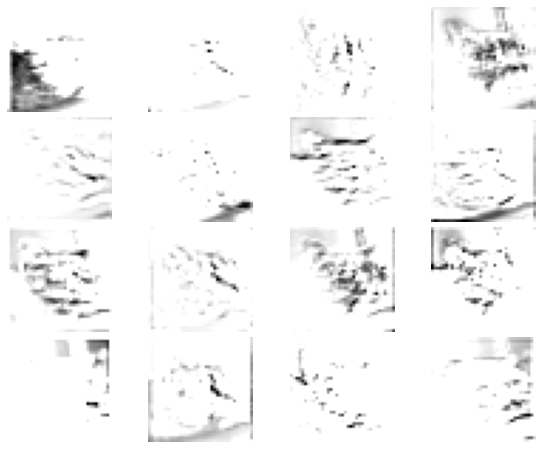

Mapa de características para la imagen 8
1/1 [==============================] - 0s 27ms/step


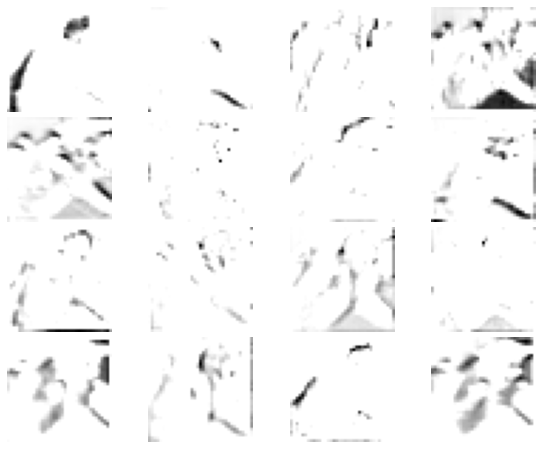

Mapa de características para la imagen 9
1/1 [==============================] - 0s 24ms/step


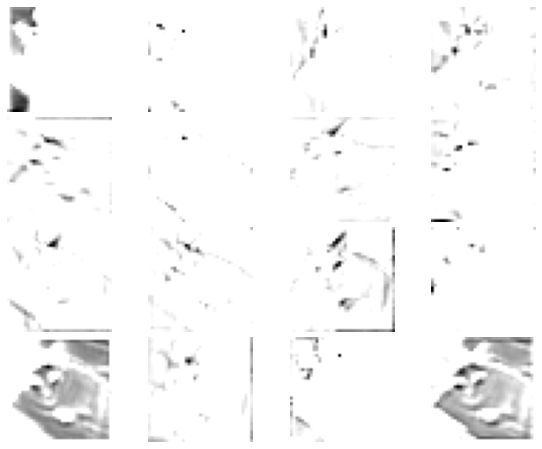

In [11]:
# Creamos un modelo que termina en la segunda capa de convolución para obtener los mapas de características
input_layer = Input(shape=input_shape)
x = model.layers[0](input_layer)
x = model.layers[1](x)
x = model.layers[2](x) # Segunda Capa de Convolución
x = model.layers[3](x)
conv_output = model.layers[4](x) # Tercera Capa de Convolución
feature_map_model = Model(inputs=input_layer, outputs=conv_output)

# Función para visualizar los mapas de características
def visualize_feature_maps(model, sample):
    # Obtenemos el mapa de características
    feature_maps = model.predict(sample[np.newaxis, ...])
    feature_maps = feature_maps[0]  # Obtenemos el resultado del primer canal
    
    # Visualizamos cada filtro
    num_filters = feature_maps.shape[-1]
    feature_map_height = feature_maps.shape[1]
    feature_map_width = feature_maps.shape[2]
    
    # Ajustamos la figura para visualizar los filtros, con 4 columnas
    fig, axes = plt.subplots(int(np.ceil(num_filters / 4)), 
                             4, 
                             figsize=(10, int(np.ceil(num_filters / 4)) * 2))  
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    
    for i in range(num_filters):
        row = i // 4  # Filas
        col = i % 4   # Columnas
        axes[row, col].imshow(feature_maps[..., i], cmap='gray_r')  
        axes[row, col].axis('off')  
    
    plt.show()

# Ejemplo de uso para un conjunto de imágenes
for i in range(10):
    sample = X_train[i]  
    print(f"Mapa de características para la imagen {i}")
    visualize_feature_maps(feature_map_model, sample)

<b>¿Qué hace la red neuronal con las características que identifica?</b>

A continuación, nos adentraremos en un aspecto intrigante de las Redes Neuronales Artificiales en general, que no solo se presenta en las redes convolucionales, y que tiene que ver con la definición de aprendizaje en el contexto de la inteligencia artificial. Ya hemos discutido en varias ocasiones ¿en qué consiste que una máquina aprenda? y probablemente hemos analizado diversos temas, como la capacidad de generalizar.

Algo que quizá no hemos tenido la oportunidad de apreciar es que las redes neuronales actúan como <b>compresoras de información</b>. A medida que las características son identificadas por las capas de la red, esta las comprime en una representación interna que encapsula lo más relevante de los datos. Esta representación compacta se conoce como <b>Vector Latente</b>. Lo fascinante de esta transformación es que, aunque los datos originales sean de alta dimensión (por ejemplo, una imagen con miles de píxeles), la red es capaz de codificarlos en un espacio de dimensiones mucho más reducidas, conservando lo esencial para realizar tareas como la clasificación, la reconstrucción o la generación de datos.

Ilustremos este concepto con experimentos, comenzando por el problema más simple.

<b>Volvamos a MNIST un rato</b>

Vamos a volver a cargar los datos, ya que probablemente los hemos sobreescrito.

In [12]:
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
import random
import matplotlib.pyplot as plt

# No necesitamos tantos datos.
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#random.seed(123) # Vamos a controlar la aleatoriedad en adelante. 
X, y = zip(*random.sample(list(zip(X_train, y_train)), 2000))

# Reshape
X, y = np.array(X, dtype='float64'), np.array(y, dtype='float64')
X = X.reshape(X.shape[0], 28, 28, 1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)
y_train_value = y_train # Guardaremos y_train con su valor original. 

# Representación categórica
y_train_value = y_train
y_train = to_categorical(y_train)
y_test = to_categorical(y_test) 

# Estandarización, se calcula con X_train y aplica a X_train y X_test
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

A continuación, vamos a construir una red neuronal de convolución cuya misión sea reproducir la misma imagen que recibe como entrada. Es decir, este nuevo modelo no tiene como objetivo clasificar los números manuscritos, sino que intenta producir una imagen lo más parecida posible a la que recibió como entrada.

La dificultad para la red estará en que, durante el procesamiento de la imagen, reduciremos significativamente el tamaño de la representación, obligándola a pasar por un cuello de botella que contenga significativamente menos parámetros donde alojar los datos. Este cuello de botella será la capa más pequeña de la red neuronal, y por lo general la colocaremos en el centro del modelo, que tendrá forma de reloj de arena. En una primera etapa, la representación original se reduce progresivamente, y luego de alcanzar el cuello de botella, se amplifica nuevamente hasta recuperar su tamaño original en la salida.

Este tipo de modelo ya no se considera Aprendizaje Supervisado, puesto que, en lugar de etiquetas, se usa la misma observación $X$ como salida esperada $Y$, lo que lo transforma en Auto-Supervisado. Este tipo de modelo se denomina <b>Autoencoder</b>.

<b>AUTOENCODER</b>

Implementaremos un autoencoder a continuación. Aprovecharemos la capacidad incorporada en Keras de generar un resumen de la arquitectura del modelo.

Por razones de simetría entre la entrada y la salida del modelo, nos conviene redimensionar las imágenes a 32x32, de manera que podamos mantener el tamaño de salida respecto a la entrada, a pesar de la reducción de tamaño durante el procesamiento. Usaremos capas de Pooling de 2x2 para reducir la representación después de cada convolución, y utilizaremos un Pooling inverso (UpSampling) luego de pasar por el cuello de botella.

<b>Notación Funcional de Keras</b>

Otra diferencia que incluiremos en la siguiente implementación es el uso de una notación distinta para declarar la red. Hasta ahora hemos utilizado la notación <b>Secuencial</b> porque nuestros modelos han sido simples, en el sentido de que correspondían a una red secuencial con un único flujo de ejecución. Sin embargo, a veces necesitamos modelos más flexibles, con múltiples entradas o salidas, o que estén compuestos por partes que pueden operar como modelos autónomos (como será este caso). Para esto, existe la notación <b>Funcional</b>.

En la notación funcional, cada capa se llama como una función que toma como entrada la salida de la capa anterior. La primera capa toma como entrada la observación original (en nuestro caso, imágenes). De esta manera, podemos darle nombres diferenciados a distintos componentes del modelo, desacoplándolos para usarlos por separado, sin perder la posibilidad de utilizarlos en conjunto.

In [13]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras import Model
import numpy as np

# Mnist son imágenes de 28x28x1, vamos a redimensionarlas a 32x32x1
def resize_images(X_train, new_size=(32, 32)):
    resized_images = []
    for img in X_train:
        img_resized = array_to_img(img).resize(new_size)  # Redimensionamos la imagen
        resized_images.append(img_to_array(img_resized))  # Convertimos de nuevo a array
    return np.array(resized_images)

# Redimensionamos las imágenes a 32x32
X_train_resized = resize_images(X_train, new_size=(32, 32))

X_shape = X_train_resized[0].shape

# Definir la arquitectura del autoencoder convolucional
input_img = layers.Input(shape=X_shape)  # Tamaño de las imágenes de entrada

# Parte del codificador (encoder)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # Representación comprimida (bottleneck)

# Parte del decodificador (decoder)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Última capa para reconstrucción

# Crear el modelo autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Mostrar la arquitectura
autoencoder.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       1280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 32)          1846

Tiene la forma de reloj de arena que se había mencionado. <br> <img src="https://editor.analyticsvidhya.com/uploads/98612autoencoder.JPG" width="500"/> </br>

El cuello de botella corresponde al <b>vector (o representación) latente</b>, que contiene la información extraída en las capas previas, comprimida en una versión con menos parámetros. Las capas previas a dicho cuello de botella constituyen el <b><i>Encoder</i></b>, y las capas hacia la salida forman el <b><i>Decoder</i></b>. En conjunto, codifican y decodifican la información.

Procedemos con el entrenamiento. Usaremos 50 epochs para mejorar el resultado, dentro de lo posible.

In [14]:
# Normalizar las imágenes de entrada entre 0 y 1
X_train_normalized = X_train_resized / 255.0

# Entrenar el autoencoder
autoencoder.fit(X_train_normalized, X_train_normalized, epochs=50, batch_size=32, shuffle=True)

Epoch 1/50
32/32 [==============================] - 5s 128ms/step - loss: 0.3757
Epoch 2/50
32/32 [==============================] - 4s 123ms/step - loss: 0.2556
Epoch 3/50
32/32 [==============================] - 5s 147ms/step - loss: 0.2366
Epoch 4/50
32/32 [==============================] - 5s 153ms/step - loss: 0.2143
Epoch 5/50
32/32 [==============================] - 5s 167ms/step - loss: 0.1990
Epoch 6/50
32/32 [==============================] - 5s 164ms/step - loss: 0.1885
Epoch 7/50
32/32 [==============================] - 5s 157ms/step - loss: 0.1821
Epoch 8/50
32/32 [==============================] - 5s 158ms/step - loss: 0.1726
Epoch 9/50
32/32 [==============================] - 5s 163ms/step - loss: 0.1653
Epoch 10/50
32/32 [==============================] - 5s 163ms/step - loss: 0.1625
Epoch 11/50
32/32 [==============================] - 5s 159ms/step - loss: 0.1554
Epoch 12/50
32/32 [==============================] - 5s 164ms/step - loss: 0.1531
Epoch 13/50
32/32 [======

Ya con el modelo entrenado, podemos observar cómo es capaz de reproducir las imágenes que recibe como entrada, conservando la mayor parte de la información original.

1/1 [==============================] - 0s 250ms/step


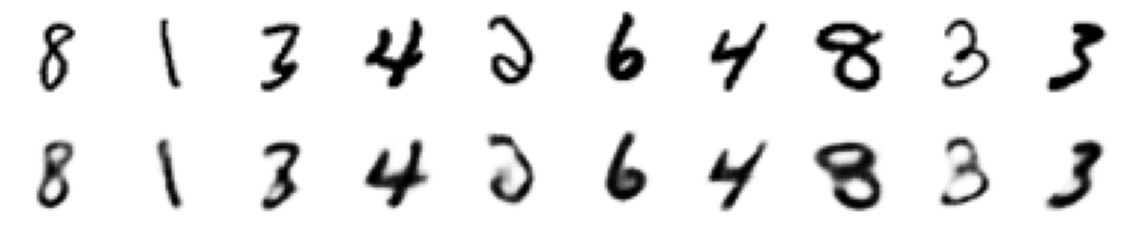

In [15]:
import matplotlib.pyplot as plt

# Seleccionamos algunas imágenes del conjunto de entrenamiento para visualizar
decoded_imgs = autoencoder.predict(X_train_normalized[:10])  # Reconstruimos las primeras 10 imágenes

n = 10  # Número de imágenes a mostrar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Mostrar imágenes originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train_normalized[i].reshape(32, 32), cmap='gray_r')  # Imagen original redimensionada
    ax.axis('off')  # No mostrar los ejes

    # Mostrar imágenes reconstruidas
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32), cmap='gray_r')  # Imagen reconstruida
    ax.axis('off')  # No mostrar los ejes

plt.show()


<b>Repitámoslo, pero con gatos</b>

Probemos nuestro autoencoder con imágenes más complejas y utilizando los tres canales de color. Para ello, volveremos a cargar los datos de gatos y perros.

In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Descargar el dataset
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
dataset = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=url, extract=True)

# Directorio de las imágenes
import os
base_dir = os.path.join(os.path.dirname(dataset), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Obteniendo la lista de imágenes de gatos y perros
cat_images = os.listdir(train_cats_dir)
dog_images = os.listdir(train_dogs_dir)

In [17]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

# Definir rutas de los directorios de datos
base_dir = os.path.join(os.path.dirname(dataset), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'validation')  

# Función para cargar imágenes y etiquetas de un directorio
def load_images_and_labels(directory, label_map, target_size=(150, 150)):
    images = []
    labels = []
    for label, label_id in label_map.items():
        class_dir = os.path.join(directory, label)
        for img_path in os.listdir(class_dir):
            img = load_img(os.path.join(class_dir, img_path), target_size=target_size)
            images.append(img_to_array(img))
            labels.append(label_id)
    return np.array(images), np.array(labels)

# Cargar imágenes y etiquetas
label_map = {'cats': 0, 'dogs': 1}
X_train, y_train = load_images_and_labels(train_dir, label_map)
X_test, y_test = load_images_and_labels(test_dir, label_map)

# Convertir etiquetas a categóricas
y_train_value = y_train
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Vamos a conservar la misma arquitectura de autoencoder que ya teníamos, y lo entrenaremos con las imágenes ajustadas a un tamaño de 128x128. No todas las imágenes eran cuadradas, por lo que podemos esperar que algunas se deformen un poco, pero siempre debería ser visible el perro o gato.

In [18]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras import Model
import numpy as np

def resize_images(X_train, new_size=(32, 32)):
    resized_images = []
    for img in X_train:
        img_resized = array_to_img(img).resize(new_size)  # Redimensionamos la imagen
        resized_images.append(img_to_array(img_resized))  # Convertimos de nuevo a array
    return np.array(resized_images)

# Redimensionamos las imágenes
X_train_resized = resize_images(X_train, new_size=(128, 128))
X_shape = X_train_resized[0].shape

# Normalizar las imágenes de entrada entre 0 y 1
X_train_normalized = X_train_resized / 255.0

# Definir la arquitectura del autoencoder convolucional
input_img = layers.Input(shape=X_shape)  # Tamaño de las imágenes de entrada

# Parte del codificador (encoder)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # Representación comprimida (bottleneck)

# Parte del decodificador (decoder)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Última capa para reconstrucción

# Crear el modelo autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Mostrar la arquitectura
autoencoder.summary()

# Entrenar el autoencoder
autoencoder.fit(X_train_normalized, X_train_normalized, epochs=50, batch_size=32, shuffle=True)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        1846

Ya con el autoencoder entrenado, visualicemos algunas imágenes del conjunto de datos de entrenamiento para apreciar cuánto se logra en la reconstrucción de la imagen después de pasar por el codificador y decodificador.

1/1 [==============================] - 0s 346ms/step


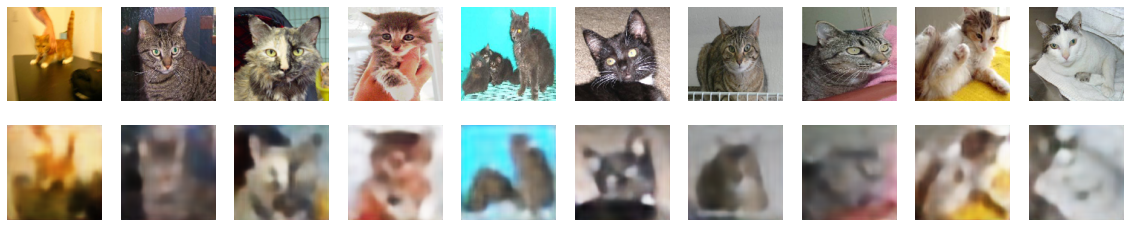

In [19]:
import matplotlib.pyplot as plt

# Seleccionamos algunas imágenes del conjunto de entrenamiento para visualizar
decoded_imgs = autoencoder.predict(X_train_normalized[:10])  # Reconstruimos las primeras 10 imágenes

n = 10  # Número de imágenes a mostrar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Mostrar imágenes originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train_normalized[i], cmap='gray_r')  # Imagen original
    ax.axis('off')  # No mostrar los ejes
 
    # Mostrar imágenes reconstruidas
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i], cmap='gray_r')  # Imagen reconstruida
    ax.axis('off')  # No mostrar los ejes

plt.show()

Podemos observar que las reconstrucciones pierden bastante detalle respecto a la imagen original, pero en general se conserva la información a un nivel suficiente para que aún sea reconocible. Consideremos que cada foto que ingresó al autoencoder corresponde a 3 canales de 128x128, es decir, 49.152 píxeles, y que en su forma reducida a vector latente tiene solo 2.320 parámetros. A pesar de ello, todavía conserva la mayor parte de la información.

<b>¿Cuál es el rol de las capas de convolución en este resultado?</b>

Podríamos estar tentados a pensar que la simple reducción mediante pooling y posterior reescalado de la imagen lograría un efecto similar, en el que aún conservamos la imagen, aunque con menor resolución. Vamos a probar si eso es correcto creando una arquitectura similar, pero omitiendo las capas de convolución, es decir, dejando solo el pooling y upsampling. Para que no se confunda con el modelo de autoencoder que ya tenemos, este será un <b>NotAutoencoder</b>. ¿Será igual de bueno?

In [20]:
# Definir la arquitectura del Notautoencoder
input_img = layers.Input(shape=X_shape)  # Tamaño de las imágenes de entrada

# Parte del codificador (encoder)
#x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(input_img)
#x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
#x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
#x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
Notencoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # Representación comprimida (bottleneck)

# Parte del decodificador (decoder)
#x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(Notencoded)
#x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
#x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
#x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
Notdecoded = layers.UpSampling2D((2, 2))(x)
#decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Última capa para reconstrucción

# Crear el modelo autoencoder
Notautoencoder = Model(input_img, Notdecoded)
Notautoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Mostrar la arquitectura
Notautoencoder.summary()

# Entrenar el autoencoder
Notautoencoder.fit(X_train_normalized, X_train_normalized, epochs=50, batch_size=32, shuffle=True)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 3)        0         
 g2D)                                                            
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 3)        0         
 g2D)                                                            
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 3)        0         
 g2D)                                                            
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 3)          0         
 g2D)                                                      

1/1 [==============================] - 0s 116ms/step


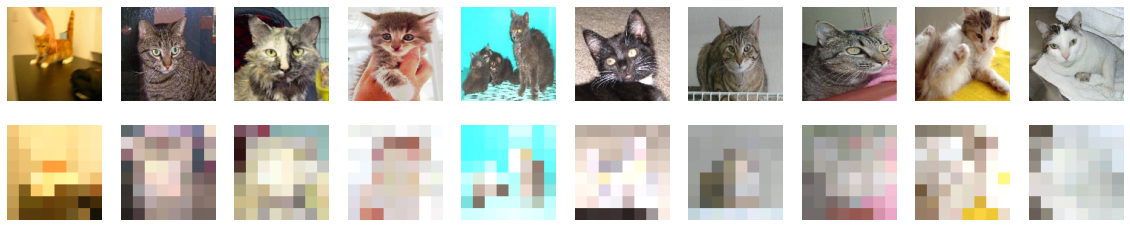

In [21]:
import matplotlib.pyplot as plt

# Seleccionamos algunas imágenes del conjunto de entrenamiento para visualizar
decoded_imgs = Notautoencoder.predict(X_train_normalized[:10])  # Reconstruimos las primeras 10 imágenes

n = 10  # Número de imágenes a mostrar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Mostrar imágenes originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train_normalized[i], cmap='gray_r')  # Imagen original
    ax.axis('off')  # No mostrar los ejes

    # Mostrar imágenes reconstruidas
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i], cmap='gray_r')  # Imagen reconstruida
    ax.axis('off')  # No mostrar los ejes

plt.show()

Se constata que las imágenes pierden mucha más información al pasar solo por el proceso de pooling y reescalado, haciendo imposible reconocer la foto original. Las capas de convolución de nuestro autoencoder, por otro lado, sí permitían que las fotos reconstruidas se parecieran en cuanto a forma y textura a las imágenes originales. Esto se debe a que, durante el entrenamiento, el modelo fue capaz de reconocer estos patrones, y por ello puede reproducirlos.

<b>¿No es esto una forma de Overfitting?</b>

Es razonable especular que, dado que nuestro modelo entrenó 50 veces con el conjunto de entrenamiento, estas imágenes quedaron <i>"memorizadas"</i> en los parámetros internos de la red. Si este fuera el caso, el éxito en la reproducción de imágenes decaería significativamente al aplicar el autoencoder a observaciones de validación que no estuvieran presentes durante el entrenamiento. Probemos si eso ocurre.

1/1 [==============================] - 0s 156ms/step


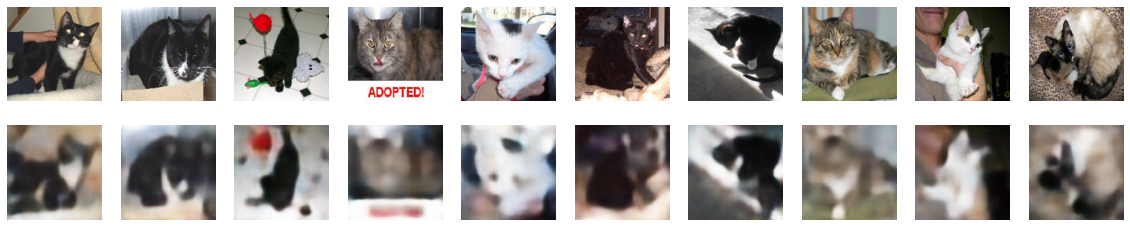

In [22]:
# Redimensionamos las imágenes ESTA VEZ DEL SET DE DATOS DE TESTEO
X_test_resized = resize_images(X_test, new_size=(128, 128))
#X_shape = X_test_resized[0].shape

# Normalizar las imágenes de entrada entre 0 y 1
X_test_normalized = X_test_resized / 255.0

# Seleccionamos algunas imágenes del conjunto de TESTEO para visualizar
decoded_imgs = autoencoder.predict(X_test_normalized[:10])  # Reconstruimos las primeras 10 imágenes

n = 10  # Número de imágenes a mostrar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Mostrar imágenes originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_normalized[i], cmap='gray_r')  # Imagen original
    ax.axis('off')  # No mostrar los ejes
 
    # Mostrar imágenes reconstruidas
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i], cmap='gray_r')  # Imagen reconstruida
    ax.axis('off')  # No mostrar los ejes

plt.show()

Al menos a simple vista, se aprecia que el autoencoder no ha perdido la capacidad de regenerar imágenes cuando estas son distintas a las de entrenamiento, es decir, <b>NO hay señales de overfitting</b>. Es posible que haya algo de pérdida en la resolución de las imágenes regeneradas en validación con respecto a las de entrenamiento, pero solo con observar estos ejemplos no es posible afirmarlo. Podríamos buscar métricas para medir esto, por ejemplo, usando las mismas funciones de pérdida, pero para el punto que queríamos afirmar, queda claro que el autoencoder está haciendo más que solo memorizar las imágenes con las que entrenó, ya que logra generalizar su capacidad al reconstruir imágenes nuevas.

Así que, con lo visto hasta este punto, probablemente estemos de acuerdo en que los autoencoders, y en particular los basados en redes convolucionales, son capaces de aprender las características de las imágenes con las que entrenan y luego usarlas para reconstruir las formas y texturas de nuevas imágenes.

<b>¿Qué más se puede hacer con los Autoencoders?</b> Nuestro siguiente paso podría ser tratar de generar nuevas imágenes, ya completamente artificiales, aprovechando las formas y texturas que ha aprendido el autoencoder.

<b>GENERACIÓN DE IMÁGENES ARTIFICIALES</b>

Este apunte casi termina, así que no esperemos avanzar mucho... pero sería una pena no aprovechar el autoencoder entrenado en un experimento adicional. Para obtener imágenes generadas artificialmente podemos usar la parte decoder de nuestro modelo. Pero el decoder debe recibir un vector latente como entrada, y dado que no estamos regenerando sino generando imágenes, no tenemos ese vector latente.

Veamos qué ocurre cuando alimentamos el decoder con vectores latentes generados aleatoriamente. Para aumentar las opciones de obtener algo interesante, probaremos distintas distribuciones de probabilidad para generar dichos vectores latentes. En teoría, con alguna entrada particular de vector latente, emergerá de la "imaginación" de nuestra red neuronal la imagen de un gatito o perrito que nunca ha sido visto antes... o al menos algunas formas y texturas más o menos reconocibles.

Distribución: normal
1/1 [==============================] - 0s 92ms/step


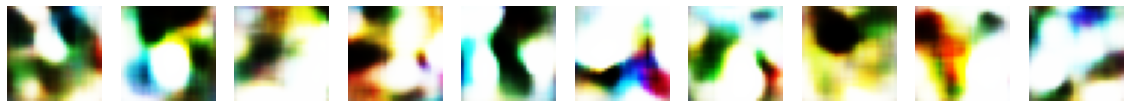

Distribución: uniform
1/1 [==============================] - 0s 33ms/step


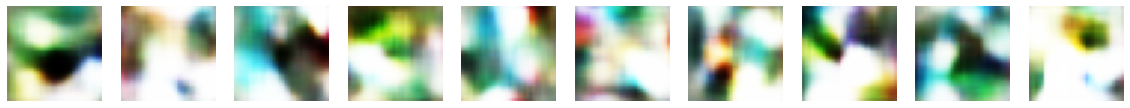

Distribución: laplace
1/1 [==============================] - 0s 28ms/step


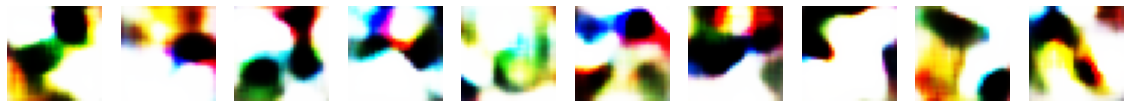

Distribución: lognormal
1/1 [==============================] - 0s 34ms/step


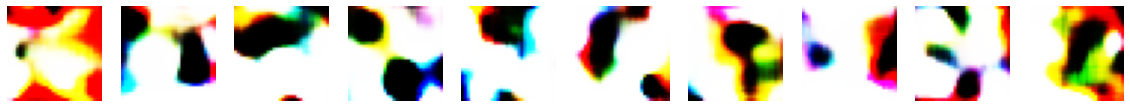

In [23]:
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt

# Extraemos el decodificador a partir del autoencoder entrenado
# La entrada del decodificador será la salida de la capa codificada (bottleneck)
latent_dim = (4, 4, 16)  # Dimensiones de la representación comprimida (última salida del encoder)

# Definir el decodificador usando las capas entrenadas del autoencoder
decoder_input = layers.Input(shape=latent_dim)

# Usamos las capas de la parte del decodificador
x = autoencoder.layers[-7](decoder_input)  # Primera capa del decodificador
x = autoencoder.layers[-6](x)              
x = autoencoder.layers[-5](x)              
x = autoencoder.layers[-4](x)              
x = autoencoder.layers[-3](x)              
x = autoencoder.layers[-2](x)              
decoded_output = autoencoder.layers[-1](x) # Última capa del decodificador

# Crear el modelo decodificador
decoder_model = Model(decoder_input, decoded_output)

# Generar imágenes artificiales usando vectores latentes aleatorios
def generate_random_images(num_images=10, distribution='normal'):
    
    # Generamos vectores latentes según la distribución seleccionada
    if distribution == 'normal':
        random_latent_vectors = np.random.normal(size=(num_images, *latent_dim))
    elif distribution == 'uniform':
        random_latent_vectors = np.random.uniform(low=-1, high=1, size=(num_images, *latent_dim))
    elif distribution == 'laplace':
        random_latent_vectors = np.random.laplace(loc=0.0, scale=1.0, size=(num_images, *latent_dim))
    elif distribution == 'lognormal':
        random_latent_vectors = np.random.lognormal(mean=0.0, sigma=1.0, size=(num_images, *latent_dim))
    else:
        raise ValueError(f"Distribución no soportada: {distribution}")

    # Usamos el decodificador para generar imágenes a partir de los vectores aleatorios
    generated_images = decoder_model.predict(random_latent_vectors)
    
    # Visualizamos las imágenes generadas
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i], cmap='gray_r')
        ax.axis('off')
    plt.show()

distribuciones = ['normal',
                'uniform',
                'laplace',
                'lognormal']
# Generamos y mostramos 100 imágenes artificiales
for dist in distribuciones:
    print('Distribución:',dist)
    generate_random_images(num_images=10, distribution=dist)

¿Vemos algo reconocible en estas imágenes? Con algo de buena voluntad de nuestra parte... quizá... <br> <img src="https://arthive.com/res/media/img/oy1200/work/7ab/313373.webp" width="200"/> </br>

In [24]:
fin = time.time() 
duración = fin - inicio
print('Se demoró {:.2f} minutos.'.format(duración/60))

Se demoró 137.18 minutos.


En los equipos de nuestro lab nos toma aproximadamente dos horas ejecutar este apunte. 
<b>Ah!, pero en COLAB usando GPU</b>...<br> <img src="https://elcomercio.pe/resizer/Ys3YhzxP1AiswFAk_EPk13s-a2o=/1200x800/smart/filters:format(jpeg):quality(75)/cloudfront-us-east-1.images.arcpublishing.com/elcomercio/4Y4ABRIEZZF2RNGL72GIZ3TWMM.jpg" width="350"/> </br>

<b>CONCLUSIÓN</b>

A lo largo de este apunte, hemos explorado el poder de los autoencoders, en particular los basados en redes convolucionales, para procesar y reconstruir imágenes. Observamos cómo estos modelos pueden comprimir la información visual en un vector latente y luego reconstruir imágenes con un nivel de detalle significativo, mostrando la capacidad de las redes para aprender y generalizar características complejas de los datos. También vimos que la presencia de capas de convolución es crucial para capturar patrones importantes, como texturas y formas, algo que no se logra solo con técnicas de reducción como el pooling.

Más allá de la reconstrucción, experimentamos con la capacidad de los autoencoders para generar nuevas imágenes artificiales, lo que abre la puerta a aplicaciones fascinantes, desde la creación de arte generado por IA hasta la síntesis de datos realistas para entrenar otros modelos. Si bien nuestro enfoque fue limitado por el tiempo y los recursos, este apunte ha demostrado cómo los autoencoders no solo son herramientas de compresión, sino también potenciales generadores de información.

Este es solo el comienzo de lo que se puede lograr con redes neuronales, y explorar más allá de los autoencoders nos permitirá comprender mejor cómo las máquinas aprenden y también crean.